In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pyplot
import pandas as pd
import probscale

plt.style.use('ggplot')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV
from statsmodels.graphics.gofplots import qqplot
from scipy import stats
from scipy.stats import shapiro

In [3]:
# Load the data
house = pd.read_csv('../../../DSI10-lessons/projects/project-3/housing.csv')
df = pd.DataFrame(house)

In [4]:
df.shape

(1460, 81)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [6]:
# Dropping those variables with less than 100 non-null values
df.drop(['Alley', 'PoolQC', 'MiscFeature'], axis=1, inplace=True)
df.shape

(1460, 78)

In [7]:
df.MSZoning.unique() # C denotes commercial properties

array(['RL', 'RM', 'C (all)', 'FV', 'RH'], dtype=object)

In [8]:
# Delete all data with MSZoning = C, which appears to have 10 observations
df = df[df['MSZoning'] != 'C (all)']

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1450 entries, 0 to 1459
Data columns (total 78 columns):
Id               1450 non-null int64
MSSubClass       1450 non-null int64
MSZoning         1450 non-null object
LotFrontage      1191 non-null float64
LotArea          1450 non-null int64
Street           1450 non-null object
LotShape         1450 non-null object
LandContour      1450 non-null object
Utilities        1450 non-null object
LotConfig        1450 non-null object
LandSlope        1450 non-null object
Neighborhood     1450 non-null object
Condition1       1450 non-null object
Condition2       1450 non-null object
BldgType         1450 non-null object
HouseStyle       1450 non-null object
OverallQual      1450 non-null int64
OverallCond      1450 non-null int64
YearBuilt        1450 non-null int64
YearRemodAdd     1450 non-null int64
RoofStyle        1450 non-null object
RoofMatl         1450 non-null object
Exterior1st      1450 non-null object
Exterior2nd      1450 non

In [10]:
# Notice a large number of NA in 'LotFrontage'. Examine 'lots' grouping
df_lots = df[['LotFrontage', 'LotArea', 'LotConfig', 'LotShape']]
grouped_lots = df_lots.groupby(['LotShape'])
grouped_lots.mean()

,LotFrontage,LotArea
LotShape,,
IR1,76.003165,11901.635611
IR2,76.500000,23733.658537
IR3,138.428571,41338.200000
Reg,67.052257,8869.655022


In [11]:
grouped_lots2 = df_lots.groupby(['LotConfig'])
grouped_lots2.count()

,LotFrontage,LotArea,LotShape
LotConfig,,,
Corner,199,261,261
CulDSac,45,94,94
FR2,33,47,47
FR3,4,4,4
Inside,910,1044,1044


In [12]:
df_LotFrontage_NA = df_lots.loc[(df['LotFrontage'].isnull())]
df_LotFrontage_NA.columns

Index(['LotFrontage', 'LotArea', 'LotConfig', 'LotShape'], dtype='object')

In [13]:
df_LotFrontage_NA.LotFrontage.isnull().sum()

259

In [14]:
# A reasonable assumption is that LotFrontage is linked to LotConfig and LotShape, and
# the other 'Lot' variables have all observations
# So I will replace all NA in LotFrontage with its mean based on LotShape
df_LotFrontage_NA = df_lots.loc[(df['LotFrontage'].isnull())]

df_LotFrontage_NA['LotFrontage'] = df_LotFrontage_NA.apply(lambda x: 76.00 if (x[3] == 'IR1') 
                                                           else x[0], axis=1)
df_LotFrontage_NA['LotFrontage'] = df_LotFrontage_NA.apply(lambda x: 76.50 if (x[3] == 'IR2') 
                                                           else x[0], axis=1)
df_LotFrontage_NA['LotFrontage'] = df_LotFrontage_NA.apply(lambda x: 138.43 if (x[3] == 'IR3') 
                                                           else x[0], axis=1)
df_LotFrontage_NA['LotFrontage'] = df_LotFrontage_NA.apply(lambda x: 67.05 if (x[3] == 'Reg') 
                                                           else x[0], axis=1)

C:\Users\Tan\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\Tan\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\Users\Tan\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

In [15]:
LotFront_fills = df_LotFrontage_NA.LotFrontage
LotFront_fills.count()

259

In [16]:
df.LotFrontage.isnull().sum()

259

In [17]:
# Filling the 'LotFrontage' null values with the LotFront_fills series in order of index number
df.loc[df.LotFrontage.isnull(), 'LotFrontage'] = LotFront_fills
df.LotFrontage.isnull().sum()

0

In [18]:
# Adding structure age variable depending if there was a major remodeling
df['Age'] = df.apply(lambda x: x['YrSold']-x['YearBuilt'] if (x['YearBuilt']<x['YearRemodAdd']) 
                                                           else (x['YrSold']-x['YearRemodAdd']), axis=1)

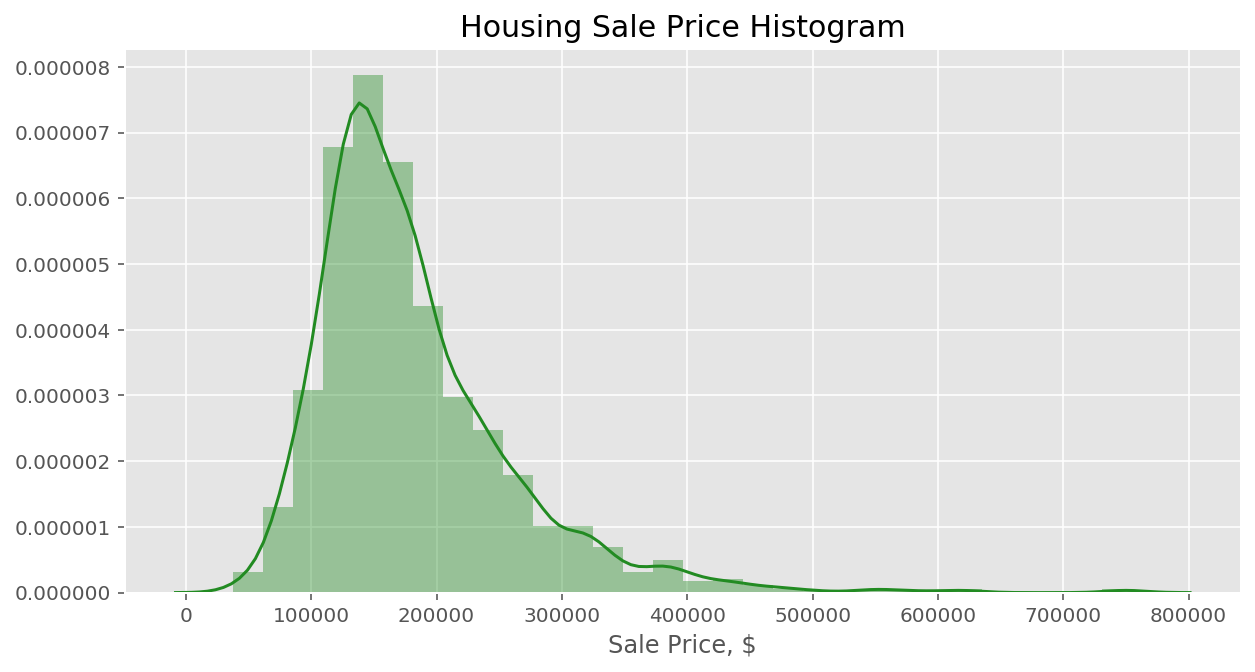

In [19]:
# The right-skew to the SalePrice is obvious in the histogram, showing that SalePrice does not have
# a normal distribution
fig, ax = plt.subplots(figsize=(10,5))

sns.distplot(df.SalePrice, bins=30, kde=True, ax=ax, color='forestgreen')
plt.title('Housing Sale Price Histogram', fontsize=15)
plt.xlabel('Sale Price, $', fontsize=12);

### Creating variables on property area/size

In [20]:
# One of the key characteristic affecting house prices in the size of the property.
# Here we examine the basement square footage variables. 
df[['BsmtFinSF1', 'BsmtFinSF2', 'TotalBsmtSF', 'BsmtUnfSF']].head()

,BsmtFinSF1,BsmtFinSF2,TotalBsmtSF,BsmtUnfSF
0,706,0,856,150
1,978,0,1262,284
2,486,0,920,434
3,216,0,756,540
4,655,0,1145,490


In [21]:
# Here we examine the above ground square footage variables. The first column is the sum of the other two.
df[['GrLivArea', '1stFlrSF', '2ndFlrSF']].head()

,GrLivArea,1stFlrSF,2ndFlrSF
0,1710,856,854
1,1262,1262,0
2,1786,920,866
3,1717,961,756
4,2198,1145,1053


In [22]:
df.GrLivArea.describe()

count    1450.000000
mean     1517.698621
std       525.154207
min       334.000000
25%      1131.250000
50%      1466.000000
75%      1779.000000
max      5642.000000
Name: GrLivArea, dtype: float64

In [23]:
# Create a total "finished" basement square footage variable
df['BaseLivArea'] = df.TotalBsmtSF - df.BsmtUnfSF

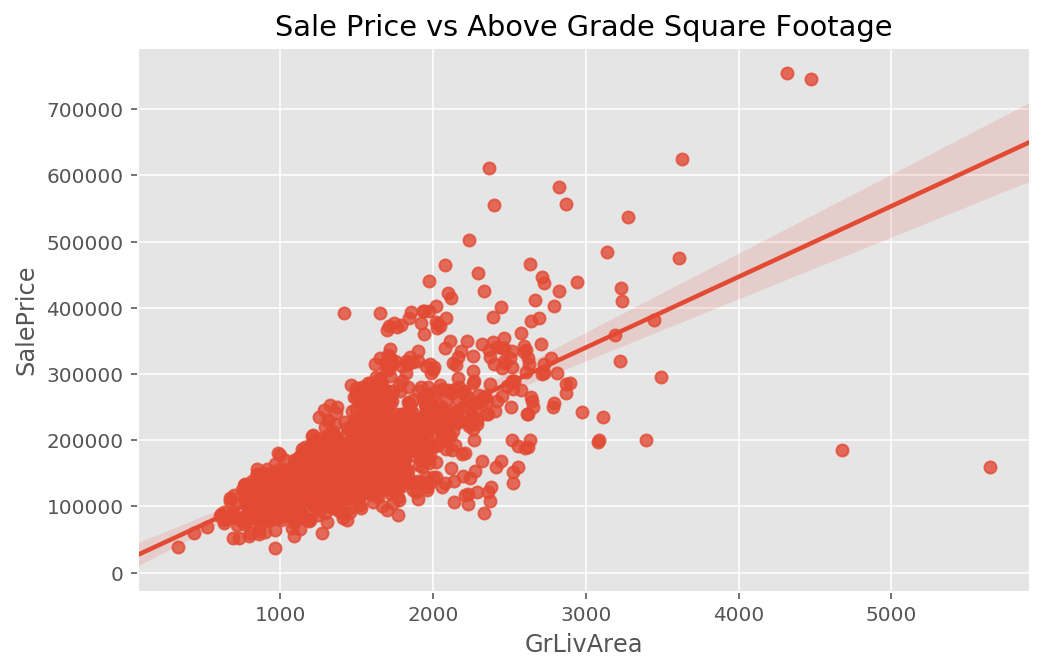

In [24]:
# Clear positive relationship between 'TSF' and 'SalePrice' variables, which is what one would expect.
# The larger the house, the higher its price, ceteris paribus
fig, ax = plt.subplots(figsize=(8,5))

sns.regplot(x="GrLivArea", y="SalePrice", data=df, ax=ax) 
ax.set_title('Sale Price vs Above Grade Square Footage')
plt.show()

In [25]:
# A simple OLS regression of TSF on the SalePrice gives an R-squared of 50% by itself!
ols = LinearRegression()

X_GLA = df[['GrLivArea']]
y_SalePrice = df.SalePrice

ols.fit(X_GLA, y_SalePrice)
print("R-squared of Total Square Footage on Sale Price:", ols.score(X_GLA, y_SalePrice))
#print("Intercept:", ols.intercept_)
#print("Coefficient:", ols.coef_)

R-squared of Total Square Footage on Sale Price: 0.5021961681419125


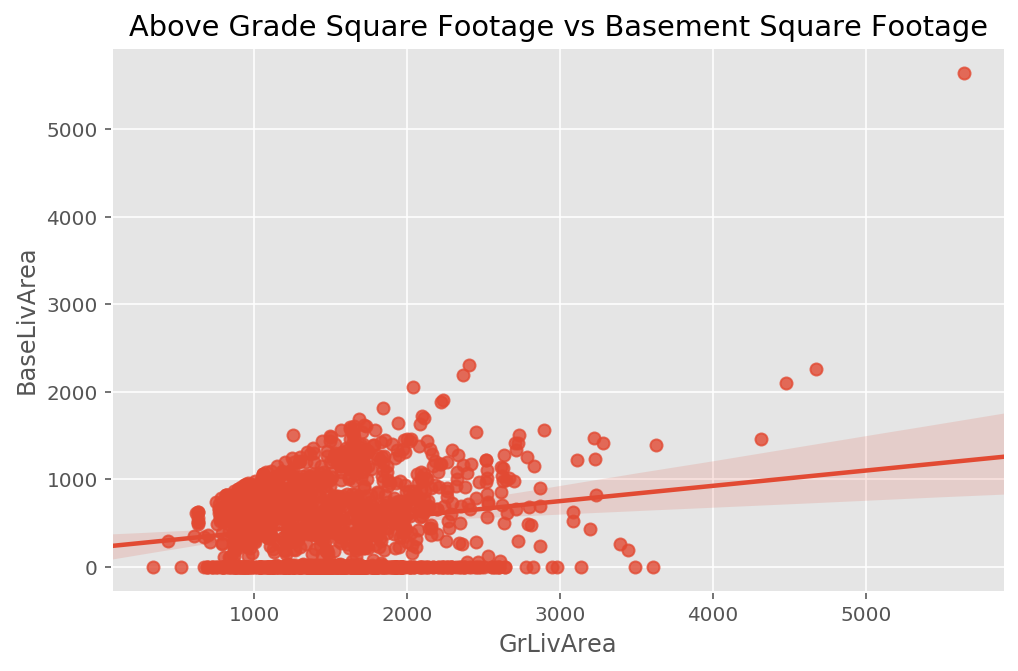

In [26]:
# There also appears to be a positive relationship between 'GrLivArea' and 'BaseLivArea', plus
# there seems to be greater variation in 'BaseLivArea' as 'GrLivArea' increases
fig, ax = plt.subplots(figsize=(8,5))

sns.regplot(x="GrLivArea", y="BaseLivArea", data=df, ax=ax) 
ax.set_title('Above Grade Square Footage vs Basement Square Footage')
plt.show()

In [27]:
df[['SalePrice', 'GrLivArea', 'BaseLivArea']].describe()

,SalePrice,GrLivArea,BaseLivArea
count,1450.000000,1450.000000,1450.000000
mean,181654.942069,1517.698621,492.033103
std,79176.485241,525.154207,476.317669
min,37900.000000,334.000000,0.000000
25%,130000.000000,1131.250000,0.000000
50%,163945.000000,1466.000000,468.000000
75%,214000.000000,1779.000000,794.750000
max,755000.000000,5642.000000,5644.000000


### Searching for outlier observations

In [28]:
# There are 40 instances of 'SalePrice' being 2.5 std above the mean
df.SalePrice[(df.SalePrice > 181654.9 + 2.5*79176.5)].count()

40

In [29]:
# But there are zero cases of the opposite
df.SalePrice[(df.SalePrice < 181654.9 - 2.5*79176.5)].count()

0

In [30]:
# There are 24 instances of 'GrLivArea' being 2.5 std above the mean
df.GrLivArea[(df.GrLivArea > 1517.7 + 2.5*525.2)].count()

24

In [31]:
# Again, zero cases of the opposite
df.GrLivArea[(df.GrLivArea < 1517.7 - 2.5*525.2)].count()

0

In [32]:
# There are 12 instances of 'GrLivArea' being 2.5 std above the mean
df.BaseLivArea[(df.BaseLivArea > 492 + 2.5*476.3)].count()

12

In [33]:
# Zero cases again of the opposite
df.BaseLivArea[(df.BaseLivArea < 492 - 2.5*476.3)].count()

0

In [34]:
df.shape

(1450, 80)

In [35]:
# 12 outlier observations are excluded
df_exout = df[(df.SalePrice < 181654.9 + 2.5*79176.5)]
df_exout = df[(df.GrLivArea < 1517.7 + 2.5*525.2)]
df_exout = df[(df.BaseLivArea < 492 + 2.5*476.3)]
df_exout.shape 

(1438, 80)

It's no brainer that the larger the house, the higher the same price. Real estate professionals tend to speak about a property's value in per unit terms, in this case it would be the price per square foot. So I construct a price per square foot measure using 'GrLivArea' as the denominator. In the US, the basement square footage is typically not cited in housing sames and surveyors tend not to count basement size to a house's official square footage. As such, I will have two property size measures: 'GrLivArea' and 'BaseLivArea'.

In [36]:
df_exout['PriceSF'] = df_exout.SalePrice / df_exout.GrLivArea

C:\Users\Tan\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


### Searching for non-commercial transactions

In [37]:
print(df_exout.SalePrice.mean())
print(df_exout.PriceSF.mean())

179872.68567454797
120.62222070116422


In [38]:
# 115 of these "abnormal" sale transactions are listed as "abnormal" or to family members, 
# and their mean SalePrice is well below the overall mean SalePrice
print(df_exout.SalePrice[(df_exout.SaleCondition == 'Abnorml') | (df_exout.SaleCondition == 'Family')].count())
df_exout.SalePrice[(df_exout.SaleCondition == 'Abnorml') | (df_exout.SaleCondition == 'Family')].mean()

115


145389.58260869567

In [39]:
# Even the mean 'PriceSF' of these "abnormal" sales is well below the overall mean
df_exout.PriceSF[(df_exout.SaleCondition == 'Abnorml') | (df_exout.SaleCondition == 'Family')].mean()

104.61853679156395

I chose to exclude these 115 "abnormal" sale transactions from the analysis. The reason is that if these transactions are not fully commercial in nature, then their inclusion in the dataset will detract from the "economic" or commercial relationship between a property's characteristic and its price. In other words, these "abnormal" transactions will introduce bias into the model estimates.

In [40]:
df_exout = df_exout[(df_exout.SaleCondition != 'Abnorml')]
df_exout = df_exout[(df_exout.SaleCondition != 'Family')]
df_exout.shape

(1323, 81)

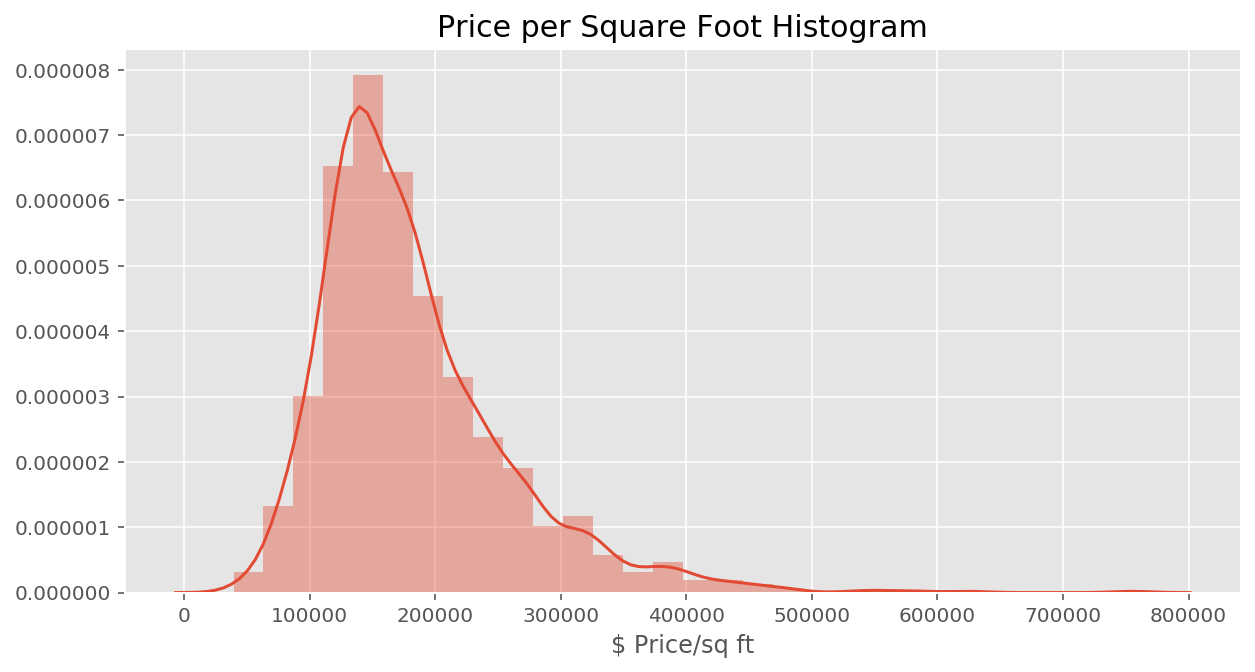

In [41]:
# Despite all the measures above, 'SalePrice' still very skewed to the right
fig, ax = plt.subplots(figsize=(10,5))
sns.distplot(df_exout.SalePrice, bins=30, kde=True, ax=ax)
plt.title('Price per Square Foot Histogram', fontsize=15)
plt.xlabel('$ Price/sq ft', fontsize=12);

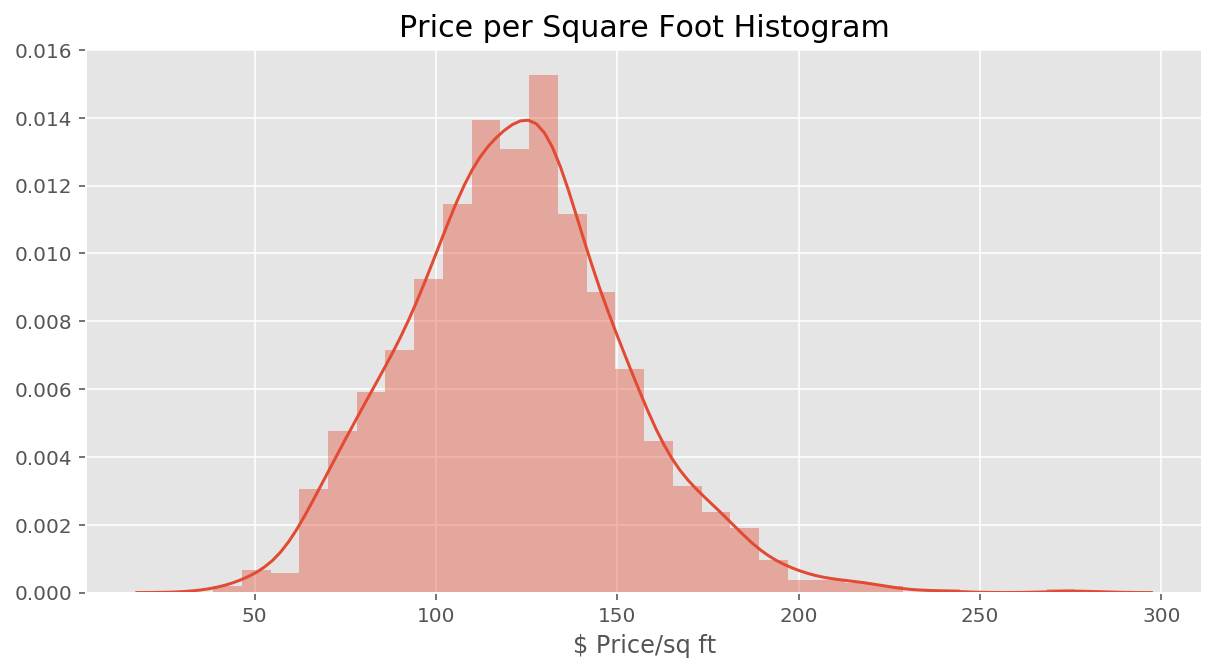

In [42]:
# Much less of a right-skew to the price per square foot, but still some
fig, ax = plt.subplots(figsize=(10,5))
sns.distplot(df_exout.PriceSF, bins=30, kde=True, ax=ax)
plt.title('Price per Square Foot Histogram', fontsize=15)
plt.xlabel('$ Price/sq ft', fontsize=12);

I created the 'Age' variable above. Apart from showing a negative relationship between 'Age' and 'SalePrice', there is also a lot of variation at the upper end of the 'Age' values.

### Log transformation of the target variable

In [43]:
# Transform both sale price variables by taking the natural log, as is typical in economic studies
# Apart from reducing the skew in the distribution, the log transformation also helps to better estimate non-linear 
# effects from the regressors to the target variable.
df_exout['LnSalePrice'] = np.log(df_exout.SalePrice)
df_exout['LnPriceSF'] = np.log(df_exout.PriceSF)

In [44]:
df_exout[['LnPriceSF', 'PriceSF', 'LnSalePrice', 'SalePrice']].head(3)

,LnPriceSF,PriceSF,LnSalePrice,SalePrice
0,4.803446,121.929825,12.247694,208500
1,4.968558,143.819334,12.109011,181500
2,4.829433,125.139978,12.317167,223500


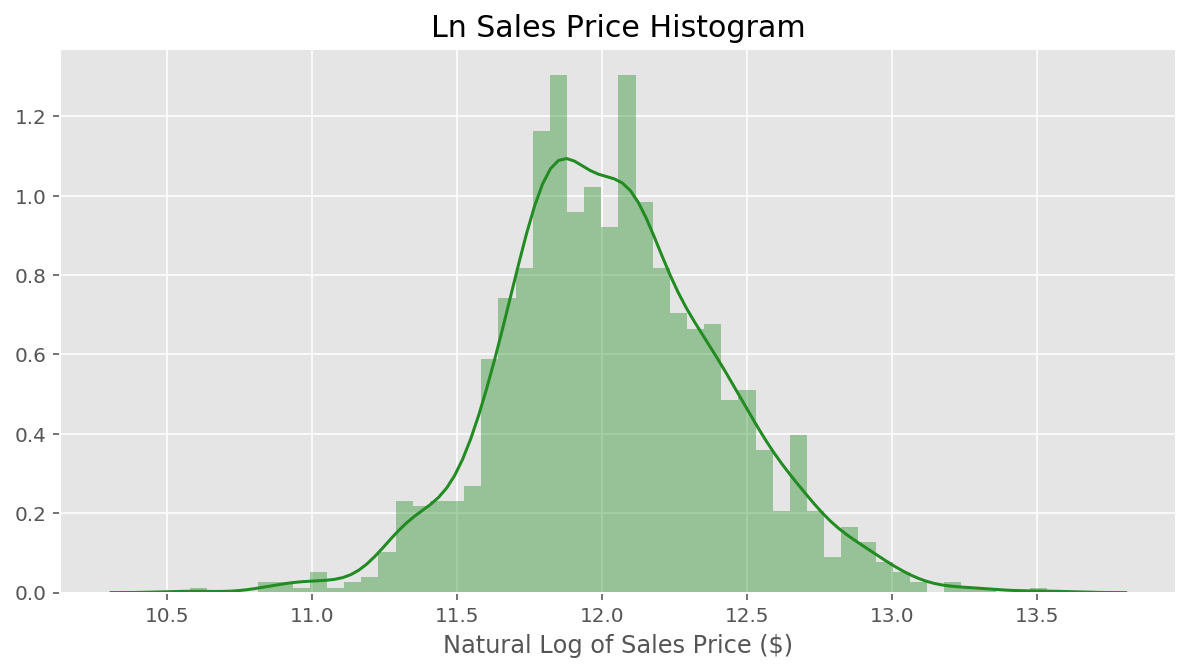

In [45]:
# The histogram of the ln SalePrice is clearly more symmetric
fig, ax = plt.subplots(figsize=(10,5))
sns.distplot(df_exout.LnSalePrice, bins=50, kde=True, ax=ax, color='forestgreen')
plt.title('Ln Sales Price Histogram', fontsize=15)
plt.xlabel('Natural Log of Sales Price ($)', fontsize=12);

C:\Users\Tan\Anaconda3\lib\site-packages\probscale\probscale.py:44: RuntimeWarning: invalid value encountered in sign
  return numpy.sign(z) * numpy.sqrt(numpy.sqrt(_b**2 - _c) - _b)
C:\Users\Tan\Anaconda3\lib\site-packages\probscale\probscale.py:32: RuntimeWarning: invalid value encountered in sign
  return numpy.sign(x) * numpy.sqrt(1.0 - numpy.exp(guts))


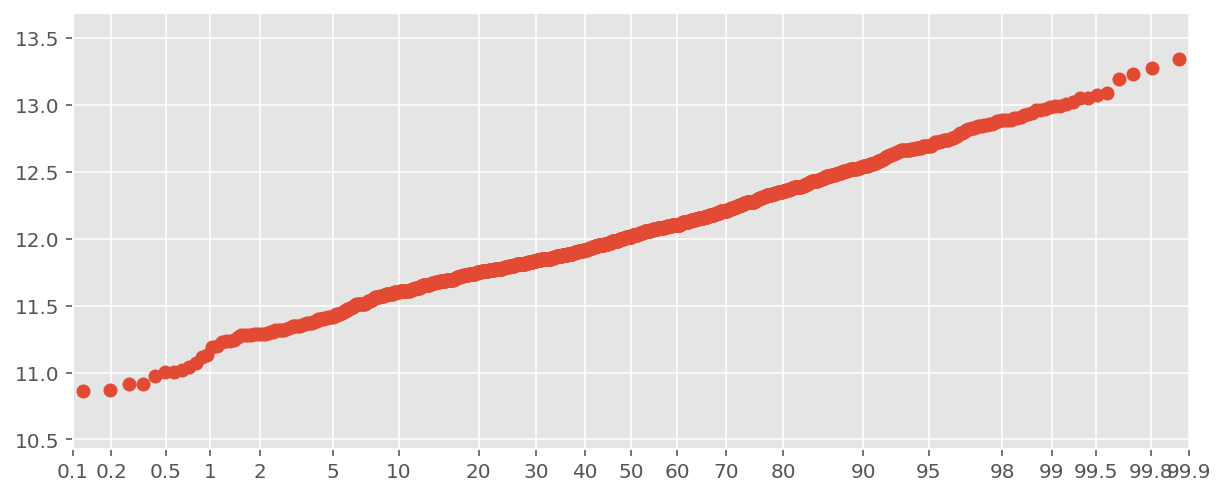

In [46]:
# Natural log of 'SalePrice' is closer to a normal distribution
fig, ax = plt.subplots(figsize=(10,4))
fig = probscale.probplot(df_exout.LnSalePrice, ax=ax, plottype='prob')

ax.set_xlim(0.1, 99.9)
ax.set_xscale('prob')
sns.despine(fig=fig)

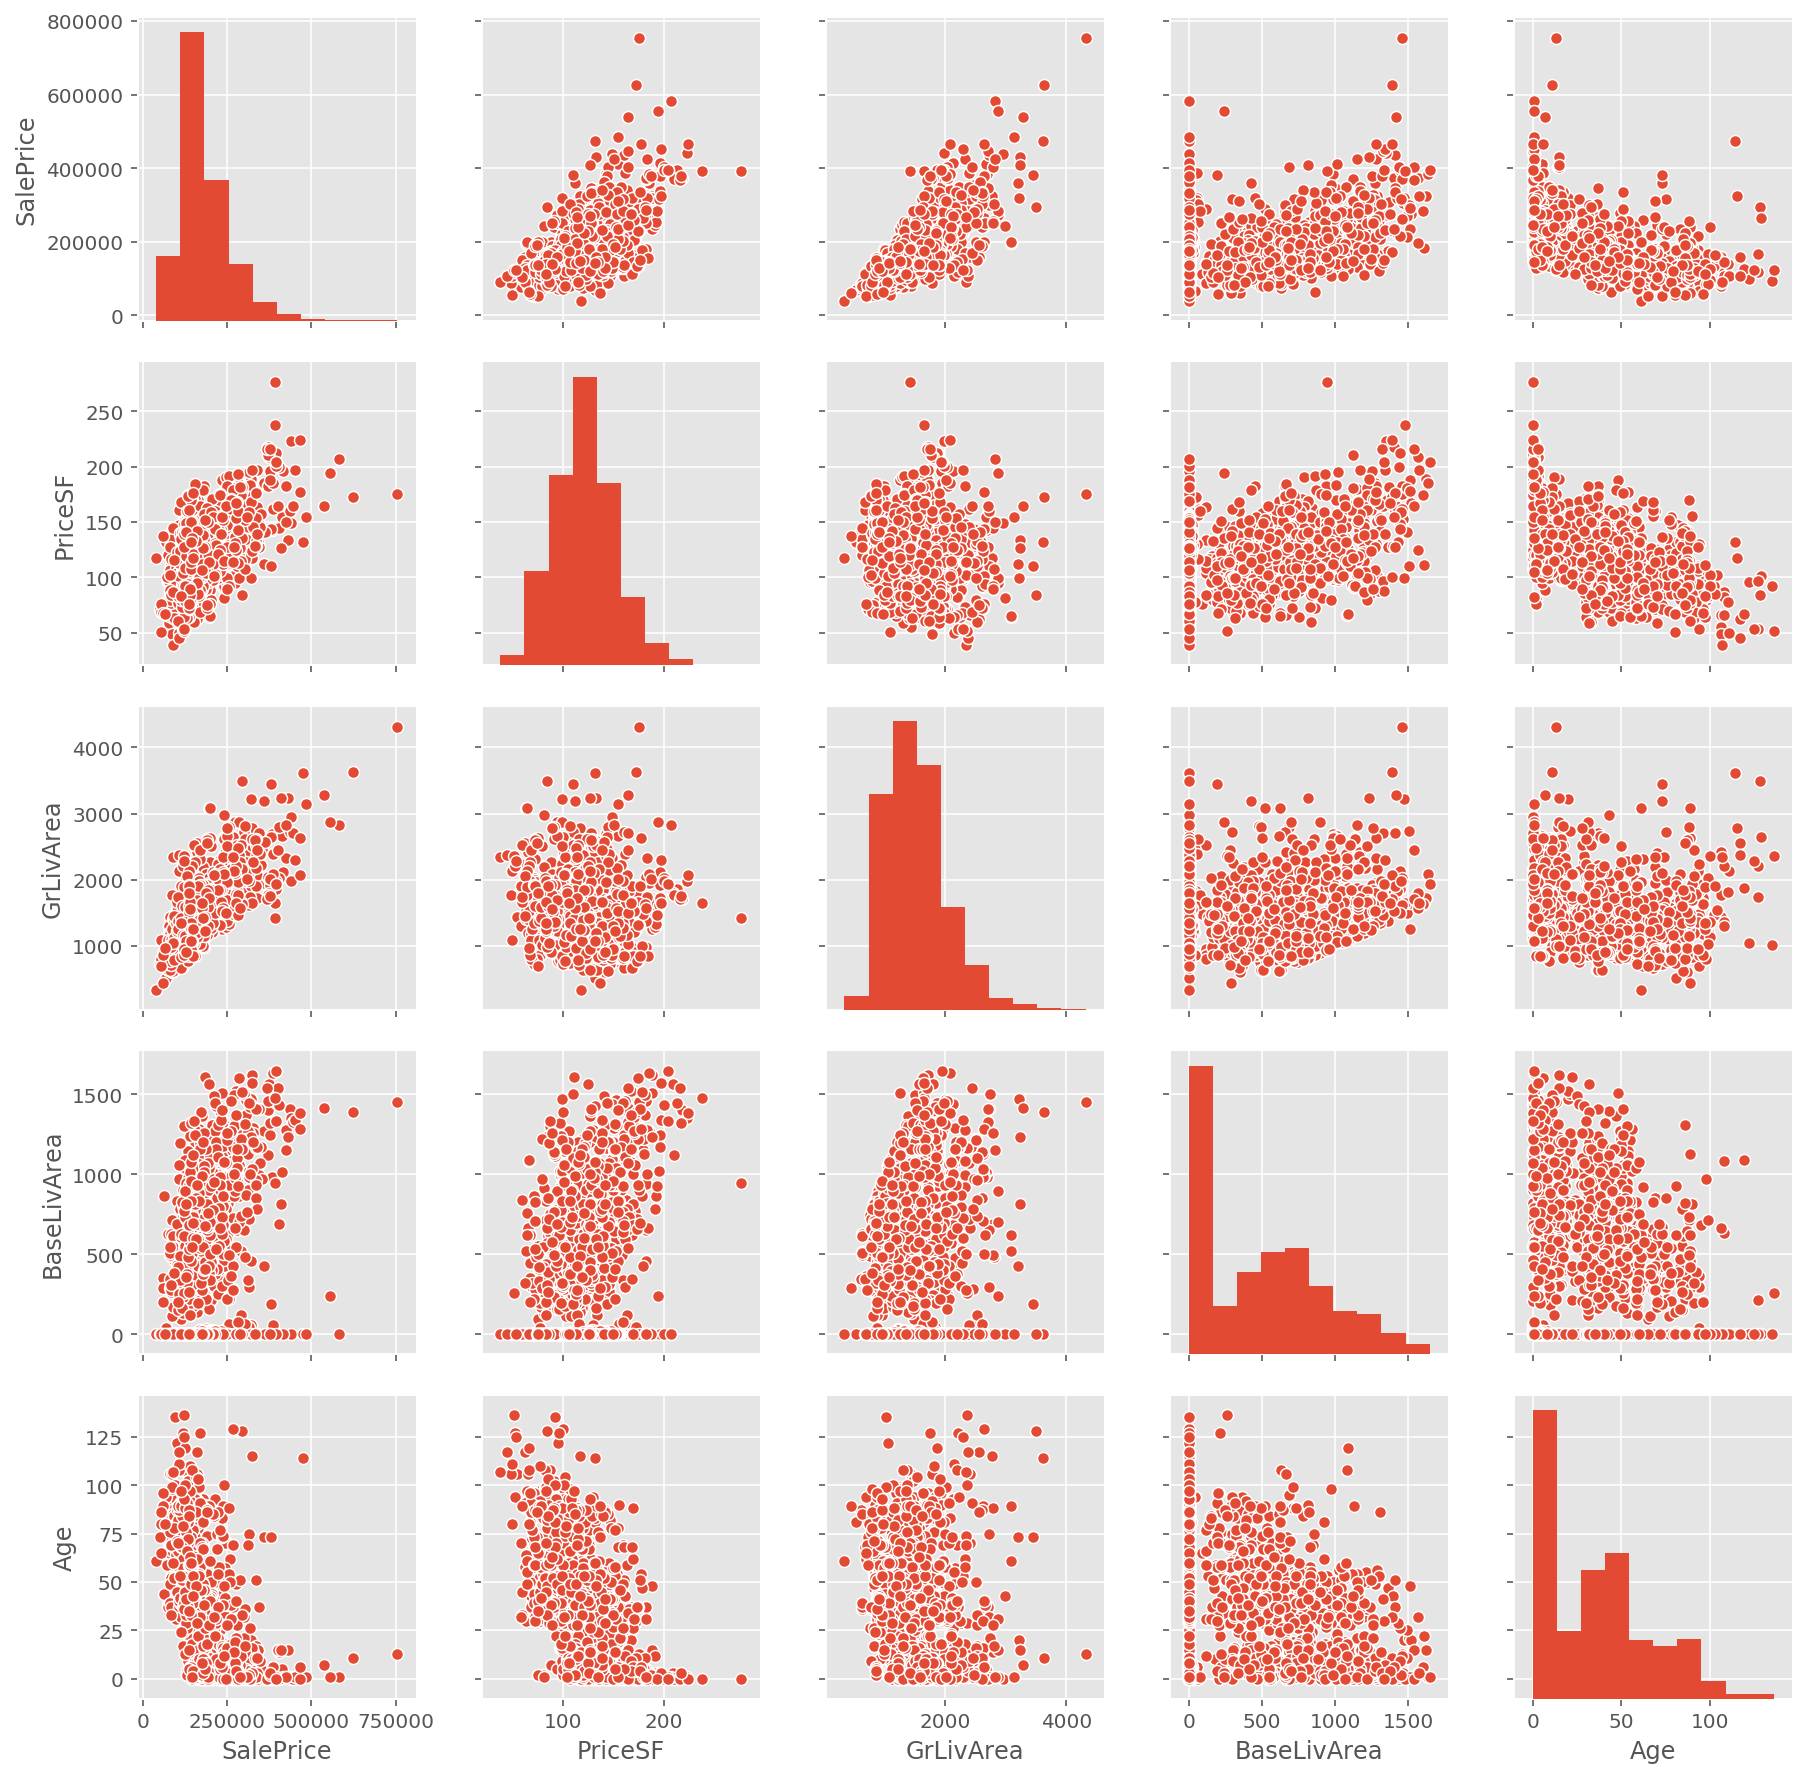

In [47]:
sns.pairplot(df_exout[['SalePrice', 'PriceSF', 'GrLivArea', 'BaseLivArea', 'Age']]);

Looking at the scatterplots of these key variables I have been working on, several interesting observations come out. Although 'PriceSF' doesn't seem to a have a linear relationship with 'GrLivArea', it does appear to have a positive correlation with 'BaseLivArea'. This suggests that the size of the finished basement helps to raise 'PriceSF', which makes sense as it adds value to the property separate from 'GrLivArea'. Another interesting observation is that 'Age' seems to have more of a linear relationship with 'PriceSF' than with 'SalePrice'. It is probably useful to try to include a polynomial of 2 variable for 'Age' against 'SalePrice'.

### Creating a "location" variable

In [48]:
# Examining the 'PriceSF' for the various neighbourhoods
neigh_mean = df_exout['PriceSF'].groupby(df_exout['Neighborhood']).count().sort_values()
neigh_mean

Neighborhood
Blueste      2
NPkVill      8
Veenker     10
BrDale      12
MeadowV     16
Blmngtn     17
SWISU       22
StoneBr     23
ClearCr     25
IDOTRR      26
Timber      34
NoRidge     36
Mitchel     44
Crawfor     46
BrkSide     54
SawyerW     55
NWAmes      63
Sawyer      68
NridgHt     75
Gilbert     76
Somerst     81
Edwards     90
OldTown     96
CollgCr    147
NAmes      197
Name: PriceSF, dtype: int64

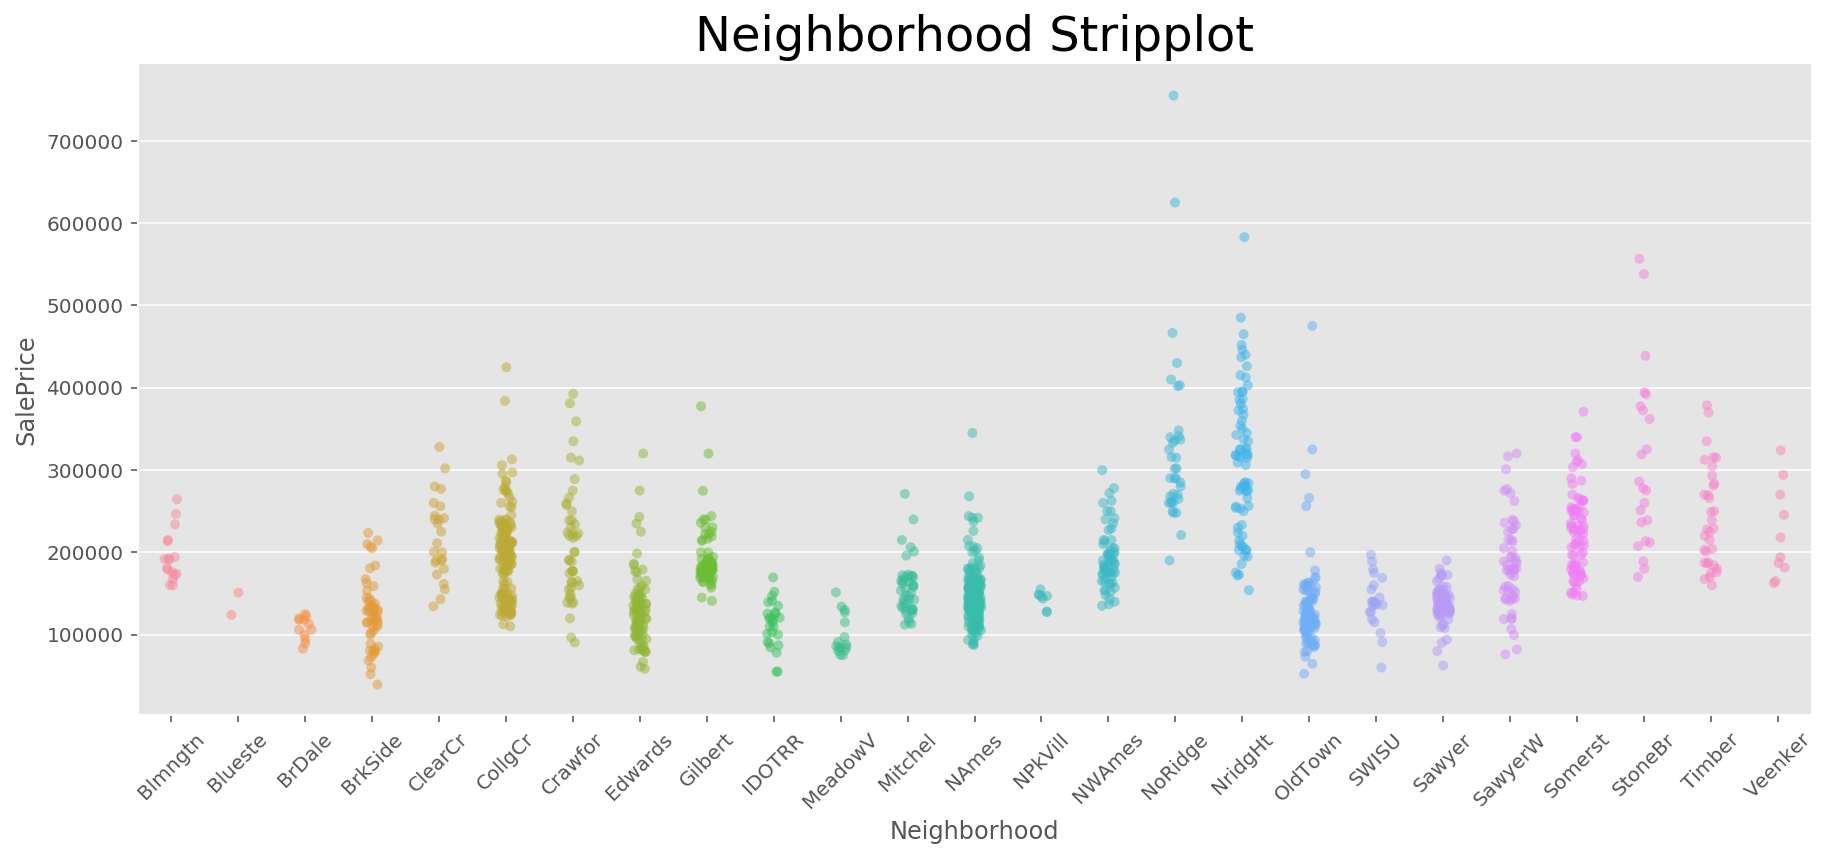

In [49]:
# Certain clusters of neighbourhoods share similar distributions of 'SalePrice' and/or 'PriceSF'
fig, ax = plt.subplots(figsize=(15,6))

sns.stripplot(x = df_exout.Neighborhood, y = df_exout.SalePrice, order = np.sort(df_exout.Neighborhood.unique()),
              jitter=0.1, alpha=0.5, ax=ax)
plt.title('Neighborhood Stripplot', fontsize=24)
plt.xticks(rotation=45)
plt.show()

We know that one key determinant of house prices is "location, location, location," which may involve difficult to measure attributes such as socio-economic status, local amenities, good schools and/or neighbourhood aesthetics etc. Every house buyer understands that the geographical location of a house is a highly important factor in its price. There are however 25 separate neighbourhoods listed under the 'Neighborhood' variable, and it is probably not advisable to have 25 dummy variables on top of other relevant factors in the regression. So it is best we reduce the number of neighbourhood dummies. 

The problems with having a dummy of each neighbourhood are: 1) there are only a handful of observations for some neighbourhoods, with less than 20 for six neighbourhoods, and less than 50 for the majority of them; 2) there would be significant multicollinearity between certain neighbourhoods that share similar characteristics, as expressed through the distribution of the 'SalePrice' or 'PriceSF' (observable in the stripplot above). 

It is a problem analogous to whether a regression of car prices should incorporate individual brand dummies (i.e. individual dummies for Mercedes, BMW and Audi), or broader classes (i.e. 'top-end' or 'German'). It is probably advisable to try to collapse this neighbourhood factor into just several ordinal categories, and this is especially true in this case when the number of observations are simply inadequate to measure robustly each 25 neighbourhood's effects on housing prices. A collapsed 'Location' variable could offer more stable coefficient estimates, and hence reduce the model's variance across different samples. 

That said, I will also run the final model with the individual 'Neighborhood' dummies to check how the results compare.

I was at first tempted to cluster the neighbourhoods by 'PriceSF', but that would be creating an explanatory variable that would be highly correlated to the target variable. A usual proxy would be to take average household income as a measure of a location/neighbourhood's desirability, but we do not have such data at hand. Instead, I looked at using some proxies from the available variables to construct the desirability of a neighbourhood, namely the variables on build quality and condition. The motivation for this methodology is that the more "desirable" a neighbourhood, the better the quality of its housing structures and their condition. 

In [50]:
# Creating a new numeric ordinal variable for 'Functional'
def functional_numeric(x):
    if 'Typ' in x:
        return 8
    elif 'Min1' in x:
        return 7
    elif 'Min2' in x:
        return 6
    elif 'Mod' in x:
        return 5
    elif 'Maj1' in x:
        return 4
    elif 'Maj2' in x:
        return 3
    elif 'Sev' in x:
        return 2    
    else:
        return 1
    
df_exout['Functional_Num'] = df_exout.Functional.map(functional_numeric)

In [51]:
# Creating a new numeric ordinal variable for 'ExterCond'
def extercond_numeric(x):
    if 'Ex' in x:
        return 5
    elif 'Gd' in x:
        return 4
    elif 'TA' in x:
        return 3
    elif 'Fa' in x:
        return 2
    else:
        return 1
    
df_exout['ExterCond_Num'] = df_exout.ExterCond.map(extercond_numeric)

In [52]:
# Creating a new numeric ordinal variable for 'ExterQual'
def exterqual_numeric(x):
    if 'Ex' in x:
        return 5
    elif 'Gd' in x:
        return 4
    elif 'TA' in x:
        return 3
    elif 'Fa' in x:
        return 2
    else:
        return 1
    
df_exout['ExterQual_Num'] = df_exout.ExterQual.map(exterqual_numeric)

In [53]:
print(df_exout['OverallQual'].mean())
print(df_exout['OverallCond'].mean())
print(df_exout['ExterQual_Num'].mean())
print(df_exout['ExterCond_Num'].mean())
print(df_exout['Functional_Num'].mean())

6.130763416477702
5.597883597883598
3.4119425547996975
3.0823885109599396
7.842025699168556


Construct the location desirability proxy from the 5 individual mean-standardised variables listed above. The construction methodology implies a stronger weighting to the external quality/condition of the building.

In [54]:
df_exout['Location'] = ((df_exout['OverallQual']/df_exout['OverallQual'].mean()) 
            + (df_exout['OverallCond']/df_exout['OverallCond'].mean())
            + (df_exout['ExterQual_Num']/df_exout['ExterQual_Num'].mean())
            + (df_exout['ExterCond_Num']/df_exout['ExterCond_Num'].mean()) 
            + (df_exout['Functional_Num']/df_exout['Functional_Num'].mean()))

In [55]:
df_exout.Location.describe()

count    1323.000000
mean        5.000000
std         0.447840
min         2.086847
25%         4.744546
50%         5.037634
75%         5.263136
max         7.346573
Name: Location, dtype: float64

In [56]:
df_exout['Location'].groupby([df_exout.Neighborhood]).mean().sort_values()

Neighborhood
MeadowV    4.576512
Edwards    4.681863
Sawyer     4.754171
IDOTRR     4.766052
BrkSide    4.767262
BrDale     4.773128
SWISU      4.777706
Mitchel    4.808059
NAmes      4.817592
NPkVill    4.833865
ClearCr    4.921218
SawyerW    4.971129
OldTown    4.980059
Gilbert    5.028287
NWAmes     5.052715
Blueste    5.085397
CollgCr    5.124475
Timber     5.180340
Crawfor    5.220671
Blmngtn    5.229530
Somerst    5.250469
Veenker    5.378685
NoRidge    5.400802
StoneBr    5.415290
NridgHt    5.498526
Name: Location, dtype: float64

In [57]:
df_exout['SalePrice'].groupby([df_exout.Neighborhood]).count().sort_values()

Neighborhood
Blueste      2
NPkVill      8
Veenker     10
BrDale      12
MeadowV     16
Blmngtn     17
SWISU       22
StoneBr     23
ClearCr     25
IDOTRR      26
Timber      34
NoRidge     36
Mitchel     44
Crawfor     46
BrkSide     54
SawyerW     55
NWAmes      63
Sawyer      68
NridgHt     75
Gilbert     76
Somerst     81
Edwards     90
OldTown     96
CollgCr    147
NAmes      197
Name: SalePrice, dtype: int64

From the analysis above, there is a possible way to construct an ordinal measurement of locational desirability by using the percentiles of the distribution of the new 'Location' variable. I decided that with no additional information or insight, I should just allocate 4 ordinal values for 'Location': 1 (low), 2 (mid-low), 3 (mid-high) and 4 (high).

First, I sorted the 'Neighborhood' variable by the 'Location' values, then slice it in half near the median (5.04), so that there are 13 'Neighborhood' instances below and 12 above the median. This resulted in all neighbourhoods under "Gilbert", which has a mean 'Location' reading of 5.03, to fall into the 1 and 2 readings of 'Location'. I then arbitrary assigned 'Location' = 1 for the 6 lowest neighbourhoods by their mean 'Location' values, and 'Location' = 2 for the remaining 7.

As for the twelve neighbourhoods in the upper half of the 'Location' values, I simply divided them exactly in half, with the lower 6 in terms of their mean 'Location' values assigned 'Location' = 3, and the remainder assigned 'Location' = 4. In this way, I have created an ordinal 'Location' desirability score of 1 to 4. The number of observations in the data also do not appear to be too unbalanced across these four ranks, but 55.7% of the observations are in the first two 'Location' categories. 

In [58]:
def add_location(x):
    if 'MeadowV' in x or 'Edwards' in x or 'Sawyer' in x or 'IDOTRR' in x or 'Brkside' in x or 'BrDale' in x:
        return 1
    elif 'Swisu' in x or 'Mitchel' in x or 'NAmes' in x or 'NPkVill' in x or 'ClearCr' in x or 'OldTown' in x or 'SawyerW' in x:
        return 2
    elif 'Gilbert' in x or 'NWAmes' in x or 'Blueste' in x or 'CollgCr' in x or 'Timber' in x or 'Crawfor' in x:
        return 3
    else:
        return 4

In [59]:
df_exout['Location'] = df_exout.Neighborhood.map(add_location)

In [60]:
df_exout['Location'].value_counts()

2    370
3    368
4    318
1    267
Name: Location, dtype: int64

In [61]:
# Positive correlation between 'SalePrice' and 'PriceSF' with 'Location'
print(df_exout['SalePrice'].groupby(df_exout.Location).mean())
print(df_exout['PriceSF'].groupby(df_exout.Location).mean())

Location
1    138567.805243
2    149030.145946
3    201536.388587
4    237839.531447
Name: SalePrice, dtype: float64
Location
1    109.502741
2    113.181144
3    126.992546
4    137.031791
Name: PriceSF, dtype: float64


In [62]:
# Total mean house size also rises with 'Location', but the median tops out at Location 3
print(df_exout['GrLivArea'].groupby(df_exout.Location).mean())
print(df_exout['GrLivArea'].groupby(df_exout.Location).median())

Location
1    1299.187266
2    1378.581081
3    1624.383152
4    1720.066038
Name: GrLivArea, dtype: float64
Location
1    1208
2    1268
3    1625
4    1625
Name: GrLivArea, dtype: int64


It does appear that the 'Location' score does tend to correlated positively with housing prices, and somewhat with the property size.

# Other feature engineering on sale year, seasonality, zoning, and proximinity to railways & artery roads

In [63]:
# Looking at the 'SalePrice' and 'PriceSF' grouped by 'YrSold', there is an obvious impact of the financial crisis 
# that hit in 2007-2008. The mean 'SoldPrice' and 'PriceSF' in 2009 and 2010 are still lower than that for 2006.
print(df_exout.SalePrice.groupby(df_exout.YrSold).mean())
print(df_exout.PriceSF.groupby(df_exout.YrSold).mean())

YrSold
2006    187266.680297
2007    185753.683007
2008    179362.706093
2009    180489.624595
2010    180676.668750
Name: SalePrice, dtype: float64
YrSold
2006    121.296289
2007    123.239306
2008    122.645172
2009    121.034579
2010    121.662527
Name: PriceSF, dtype: float64


In [64]:
# House prices were in an uptrend in 2006-2007, but fell in 2008 and have been in a "slight" downtrend since. 
# Thus, it might be useful to incorporate this trend effect in the modelling.
df_exout.PriceSF.groupby(df_exout.YrSold).mean().pct_change()

YrSold
2006         NaN
2007    0.016019
2008   -0.004821
2009   -0.013132
2010    0.005188
Name: PriceSF, dtype: float64

In [65]:
# There is also a weak seasonal impact to housing prices over the course of the year.
# The 2nd half of the year seems to be generally better for house prices than the 1st half, especially for 'SalePrice'
salepricebymonth = df_exout.SalePrice.groupby(df_exout.MoSold).mean()
pricesfbymonth = df_exout.PriceSF.groupby(df_exout.MoSold).mean()
print(salepricebymonth, pricesfbymonth)

MoSold
1     185769.936170
2     178316.255319
3     181946.936842
4     174324.472441
5     174801.489474
6     177868.297521
7     186105.037383
8     189383.209524
9     202590.210526
10    185559.397436
11    194838.579710
12    191685.365385
Name: SalePrice, dtype: float64 MoSold
1     122.234918
2     125.687550
3     119.831374
4     119.759872
5     122.942976
6     120.380108
7     121.321433
8     122.694130
9     123.672246
10    125.833324
11    121.836487
12    126.344704
Name: PriceSF, dtype: float64


In [66]:
# Creating semi-annual ordinal variable to capture the seasonality affect
def add_seasonal(x):
    if x == 1 or x == 2 or x == 3 or x == 4 or x == 5 or x == 6:
        return 0
    else:
        return 1
    
df_exout['SemiAnnual'] = df_exout.MoSold.map(add_seasonal)

In [67]:
# Higher prices in second half of the year
print(df_exout.SalePrice.groupby(df_exout.SemiAnnual).mean())
print(df_exout.PriceSF.groupby(df_exout.SemiAnnual).mean())

SemiAnnual
0    177530.252674
1    189816.506087
Name: SalePrice, dtype: float64
SemiAnnual
0    121.306139
1    122.933269
Name: PriceSF, dtype: float64


In [68]:
df_exout.SalePrice.groupby(df_exout.MSZoning).mean()

MSZoning
FV    215071.508197
RH    119509.090909
RL    191727.925189
RM    128402.405128
Name: SalePrice, dtype: float64

In [69]:
# Creating a new ordinal variable of zoning, corresponding to the mean values from 'MSZoning'
# The FV observations in 'MSZoning' are a retirement community development, named "Floating Village"
def add_zoning(x):
    if 'RH' in x:
        return 1
    elif 'RM' in x:
        return 2
    elif 'RL' in x:
        return 3
    else:
        return 4

In [70]:
df_exout['Zoning'] = df_exout.MSZoning.map(add_zoning)

In [71]:
# No linear relationship between 'GrLivArea' or 'BaseLivArea' and 'Zoning'
print(df_exout.GrLivArea.groupby(df_exout.Zoning).mean())
df_exout.BaseLivArea.groupby(df_exout.Zoning).mean()

Zoning
1    1361.909091
2    1319.625641
3    1546.495265
4    1578.770492
Name: GrLivArea, dtype: float64


Zoning
1    345.272727
2    270.328205
3    525.620265
4    318.459016
Name: BaseLivArea, dtype: float64

In [72]:
# There appears to be a sizeable jump in prices in the low density and FV categories
print(df_exout.SalePrice.groupby(df_exout.Zoning).mean())
df_exout.PriceSF.groupby(df_exout.Zoning).mean()

Zoning
1    119509.090909
2    128402.405128
3    191727.925189
4    215071.508197
Name: SalePrice, dtype: float64


Zoning
1     94.739780
2    102.520847
3    125.045797
4    136.746839
Name: PriceSF, dtype: float64

In [73]:
# There is a relationship between 'Location' and 'Zoning' with Locations 3 and 4 
# primarily in zones 3 and 4 (low density and the retirement village)
df_exout.Location.groupby(df_exout.Zoning).value_counts()

Zoning  Location
1       1             6
        3             2
        4             2
        2             1
2       2            88
        1            63
        4            30
        3            14
3       3           352
        2           281
        4           225
        1           198
4       4            61
Name: Location, dtype: int64

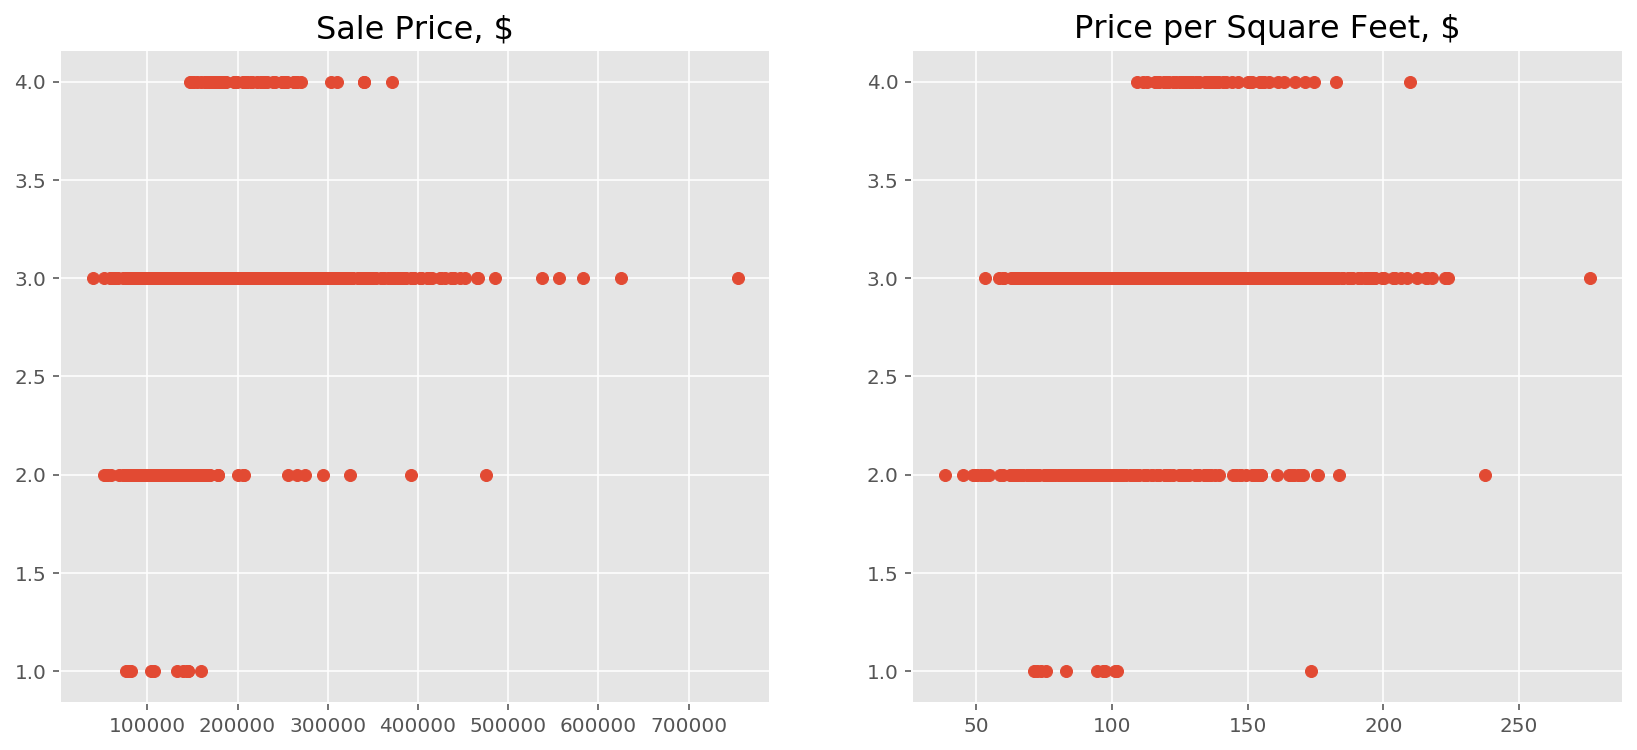

In [74]:
# There is a general increase inprices as we go from Zone 1 to 3, especially in mean 'PriceSF'
fig, ax = plt.subplots(ncols=2, figsize=(14, 6))

ax[0].scatter(df_exout.SalePrice, df_exout.Zoning)
ax[0].set_title('Sale Price, $', fontsize=16)
ax[1].scatter(df_exout.PriceSF, df_exout.Zoning)
ax[1].set_title('Price per Square Feet, $', fontsize=16)
#fig.suptitle('Sale Prices by Zone', fontsize=24)
plt.show()

In [75]:
# Analysis above suggests that it might be more useful to model 'Zoning' as dummies instead of an ordinal variable

In [76]:
df_exout.shape

(1323, 89)

In [77]:
# The overwhelming majority of observations fall into the double-'Norm' category in terms of
# Condition1 and Condition2, which is a measure of environmental condition
df_exout.Condition1.groupby(df_exout.Condition2).value_counts()

Condition2  Condition1
Artery      Artery           1
Feedr       RRAn             4
            RRNn             1
Norm        Norm          1144
            Feedr           69
            Artery          38
            RRAn            20
            PosN            17
            RRAe             9
            PosA             8
            RRNn             4
            RRNe             2
PosA        Artery           1
PosN        PosN             1
RRAe        Feedr            1
RRAn        Feedr            1
RRNn        Feedr            2
Name: Condition1, dtype: int64

In [78]:
# Previous studies have shown a negative relationship between housing prices and being adjacent 
# or near to a major roadway or a railway line.
# Creating variables to capture this negative enviromental impact
def add_roadrail1(x):
    if 'Artery' in x:
        return 1
    elif 'RRAn' in x:
        return 1
    elif 'RRNn' in x:
        return 1
    elif 'RRAe' in x:
        return 1
    elif 'RRNe' in x:
        return 1
    else:
        return 0

df_exout['RoadRail1'] = df_exout.Condition1.map(add_roadrail1)

In [79]:
def add_roadrail2(x):
    if 'Artery' in x:
        return 1
    elif 'RRAn' in x:
        return 1
    elif 'RRNn' in x:
        return 1
    elif 'RRAe' in x:
        return 1
    elif 'RRNe' in x:
        return 1
    else:
        return 0

df_exout['RoadRail2'] = df_exout.Condition2.map(add_roadrail2)

In [80]:
df_exout.RoadRail1.groupby(df_exout.RoadRail2).value_counts()

RoadRail2  RoadRail1
0          0            1239
           1              79
1          0               4
           1               1
Name: RoadRail1, dtype: int64

In [81]:
df_exout['RoadRail'] = df_exout.apply(lambda x: 1 if (x['RoadRail1'] == 1 | x['RoadRail2'] == 1) 
                                      else 0, axis=1)

In [82]:
df_exout.drop(['RoadRail1', 'RoadRail2'], axis=1, inplace=True)

In [83]:
# The RoadRail variable seems to have an impact on mean 'SalePrice' and 'PriceSF' in every 'Location'
print(df_exout.SalePrice.groupby([df_exout.RoadRail, df_exout.Location]).mean())
df_exout.PriceSF.groupby([df_exout.RoadRail, df_exout.Location]).mean()

RoadRail  Location
0         1           139472.080972
          2           149187.142012
          3           202209.635593
          4           240367.891447
1         1           127400.000000
          2           147371.875000
          3           184512.857143
          4           182938.000000
Name: SalePrice, dtype: float64


RoadRail  Location
0         1           110.408212
          2           114.523144
          3           127.662182
          4           137.484382
1         1            98.320183
          2            99.006269
          3           110.060336
          4           127.204083
Name: PriceSF, dtype: float64

### More (minor) feature engineering

In [84]:
# Transforming the 'CentralAir' dummy variable to numeric
df_exout['CentralAirNum'] = df_exout.apply(lambda x: 1 if (x['CentralAir'] == 'Y') 
                                                           else 0, axis=1)
#df_exout[['CentralAir', 'CentralAirNum']]
df_exout['CentralAirNum'].value_counts()

1    1243
0      80
Name: CentralAirNum, dtype: int64

In [85]:
# Creating variables on the positive amenities
def add_amenities1(x):
    if 'PosN' in x:
        return 1
    elif 'PosA' in x:
        return 1
    else:
        return 0

df_exout['Amenities1'] = df_exout.Condition1.map(add_amenities1)

In [86]:
def add_amenities2(x):
    if 'PosN' in x:
        return 1
    elif 'PosA' in x:
        return 1
    else:
        return 0

df_exout['Amenities2'] = df_exout.Condition2.map(add_amenities2)

In [87]:
df_exout['Amenities'] = df_exout.apply(lambda x: 1 if (x['Amenities1'] == 1 | x['Amenities2'] == 1) 
                                      else 0, axis=1)

df_exout.drop(['Amenities1', 'Amenities2'], axis=1, inplace=True)

In [88]:
# Amenities = 1 does seem to raise the mean 'SalePrice' but has mixed impact on 'PriceSF'
print(df_exout.SalePrice.groupby([df_exout.Amenities, df_exout.Location]).mean())
df_exout.PriceSF.groupby([df_exout.Amenities, df_exout.Location]).mean()

Amenities  Location
0          1           138468.436090
           2           148295.440443
           3           200072.432203
           4           237447.693038
1          1           165000.000000
           2           178500.000000
           3           238553.571429
           4           299750.000000
Name: SalePrice, dtype: float64


Amenities  Location
0          1           109.465888
           2           113.525299
           3           127.321818
           4           136.996370
1          1           119.305857
           2            99.376694
           3           118.666660
           4           142.628173
Name: PriceSF, dtype: float64

In [89]:
# Dummify 'YrSold' variable
df_exout = pd.get_dummies(df_exout, columns=['YrSold'])

In [90]:
# At this point, all the observations in the sample have full public utility service
df_exout[(df_exout.Utilities != 'AllPub')]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,SemiAnnual,Zoning,RoadRail,CentralAirNum,Amenities,YrSold_2006,YrSold_2007,YrSold_2008,YrSold_2009,YrSold_2010


In [91]:
# Summing up the above ground bathrooms and assigning to a new variable
df_exout['Bathrooms'] = df_exout.FullBath + (0.5*df_exout.HalfBath)
df_exout.Bathrooms.describe()

count    1323.000000
mean        1.775510
std         0.630675
min         0.000000
25%         1.000000
50%         2.000000
75%         2.500000
max         3.500000
Name: Bathrooms, dtype: float64

In [92]:
# There also appears to be a positive relationship between the overall quality of the housing 
# structure and the 'SalePrice' and 'PriceSF'
print(df_exout.SalePrice.groupby([df_exout.OverallQual]).mean())
df_exout.PriceSF.groupby([df_exout.OverallQual]).mean()

OverallQual
1      50150.000000
2      60000.000000
3      89705.000000
4     109826.700000
5     135148.471591
6     163158.167155
7     208416.282392
8     275290.254777
9     358350.410256
10    446417.214286
Name: SalePrice, dtype: float64


OverallQual
1      92.571273
2     105.993151
3      84.669616
4     103.577143
5     114.163715
6     115.806478
7     125.046007
8     145.624183
9     174.333352
10    173.018012
Name: PriceSF, dtype: float64

In [93]:
# Interestingly 'OverallQual' is not well correlated with 'OverallCond'
df_exout.OverallQual.corr(df_exout.OverallCond)

-0.11608641026475318

In [94]:
# But it is moderately correlated with the 'Location' variable as one would expect
df_exout.OverallQual.corr(df_exout.Location)

0.5293366067228995

In [95]:
# Overall Condition of the house appears to have mixed impact on prices
print(df_exout.SalePrice.groupby([df_exout.OverallCond]).mean())
df_exout.PriceSF.groupby([df_exout.OverallCond]).mean()

OverallCond
1     61000.000000
2    185977.333333
3    104616.200000
4    120699.812500
5    204820.665775
6    154755.687225
7    160164.940217
8    155611.619718
9    218004.761905
Name: SalePrice, dtype: float64


OverallCond
1     67.477876
2    106.711586
3     81.155025
4     85.202228
5    128.952061
6    115.033523
7    117.701800
8    119.384220
9    124.811413
Name: PriceSF, dtype: float64

In [96]:
# Dummifying other potential important "fixed" features
df_exout = pd.get_dummies(df_exout, columns=['Street'])

In [97]:
df_exout = pd.get_dummies(df_exout, columns=['KitchenQual'])

In [98]:
df_exout['Zone_ordinal'] = df_exout['Zoning']
df_exout = pd.get_dummies(df_exout, columns=['Zoning'])

In [99]:
df_exout.drop(['Street_Grvl'], axis=1, inplace=True)
df_exout.rename(columns={'Street_Pave': 'Street_dum'}, inplace=True)

In [100]:
# Creating a dummy variable for flat roofs
df_exout['FlatRoof_dum'] = df_exout.RoofStyle.apply(lambda x: 1 if x=='Flat' else 0)

In [101]:
# Creating a dummy variable for garage
df_exout['Garage_dum'] = df_exout.GarageQual.apply(lambda x: 0 if pd.isnull(x)==True else 1)

In [102]:
# Creating a dummy variable for flat property contour
df_exout['FlatContour_dum'] = df_exout.LandContour.apply(lambda x: 1 if x=='Lvl' else 0)

In [103]:
# Creating a dummy variable for houses higher than one storey
df_exout['TwoStory_dum'] = df_exout['2ndFlrSF'].apply(lambda x: 1 if x>0 else 0)

In [104]:
# Creating interactive variables between the 'Zoning' dummies and 'Location'

In [105]:
df_exout.shape

(1323, 108)

In [106]:
# Assigning 2006-2009 data to another dataset
df_0609 = df_exout.loc[df_exout['YrSold_2010'] != 1]
df_0609.shape

(1163, 108)

In [107]:
# Assigning 2010 data to another dataset
df_2010 = df_exout.loc[df_exout['YrSold_2010'] == 1]

# Regression using Ln SalePrice target on pre-2010 with 'Zoning' dummies

In [108]:
y_SP = df_0609['SalePrice']
y_lnSP = df_0609['LnSalePrice']

In [109]:
X = df_0609[['Age', 'GrLivArea', 'BaseLivArea', 'Location', 'Amenities', 'RoadRail', 'BedroomAbvGr', 'Bathrooms', 'OverallCond',
             'OverallQual', 'LotFrontage', 'LotArea', 'TwoStory_dum', 'FlatContour_dum', 'FlatRoof_dum', 'GarageArea', 
             'Garage_dum', 'CentralAirNum', 'LowQualFinSF', 'Fireplaces', 'KitchenQual_Ex', 'Zoning_2', 'Zoning_3', 
             'Zoning_4', 'YrSold_2007', 'YrSold_2008', 'YrSold_2009']]

In [110]:
X.shape

(1163, 27)

In [111]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_lnSP, test_size=0.2, random_state=1)

In [112]:
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [113]:
ols = LinearRegression()
ols.fit(X_train, y_train)

print("R-squared:", ols.score(X_train, y_train))
print("Intercept:", ols.intercept_)
print("Coefficients:", ols.coef_)

R-squared: 0.9203540427050345
Intercept: 12.042922063915366
Coefficients: [-0.08146593  0.1648707   0.04929012  0.0313328  -0.00096611 -0.01074795
 -0.00327246  0.00528845  0.05391131  0.11233252  0.01643693  0.02264189
 -0.02882557 -0.00508494 -0.0023312   0.03144656  0.00827623  0.01307867
 -0.01421075  0.01981339  0.013522    0.01226601  0.03647587  0.02462178
  0.00138457  0.00236072 -0.0005618 ]


In [114]:
# collect the coefficients
df_ols_coef = pd.DataFrame(ols.coef_, index=X_train.columns, columns=['Coefficients'])
df_ols_coef['Coef_abs'] = df_ols_coef.Coefficients.abs()

In [115]:
ols.fit(X_train, y_train) 
predictions_train = ols.predict(X_train)
predictions_test = ols.predict(X_test)
# Perform 5-fold cross validation
cv_scores = cross_val_score(ols, X_train, y_train, cv=5)

print('Training Score:', ols.score(X_train, y_train))
print('Cross validation score:', cv_scores)
print('Mean cross validation score:', cv_scores.mean())
print('Test Score:', ols.score(X_test, y_test))

Training Score: 0.9203540427050345
Cross validation score: [0.92457344 0.9055489  0.88820113 0.90568323 0.93861913]
Mean cross validation score: 0.9125251657244184
Test Score: 0.9225909713016088


In [116]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, predictions_test))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, predictions_test))  

Mean Absolute Error: 0.07880834822085875
Mean Squared Error: 0.01047214389279358


In [117]:
ols_residuals_0609 = (y_train - predictions_train)
ols_residuals_0609.describe()

count    9.300000e+02
mean    -2.674086e-16
std      1.089781e-01
min     -6.466679e-01
25%     -5.993150e-02
50%      1.375892e-03
75%      5.788969e-02
max      4.468785e-01
Name: LnSalePrice, dtype: float64

In [118]:
# Less skew and kurtosis than the 'all Neighborhood dummies' model, and marginally better result from
# Shapiro-Wilk test of normality
print("Skew:", ols_residuals_0609.skew())
print("Kurtosis:", ols_residuals_0609.kurtosis())
stat, p = shapiro(ols_residuals_0609)
print('Shapiro-Wilk test on normality=%.3f, p=%.3f' % (stat, p))

Skew: -0.33498440191087786
Kurtosis: 3.12800371826661
Shapiro-Wilk test on normality=0.968, p=0.000


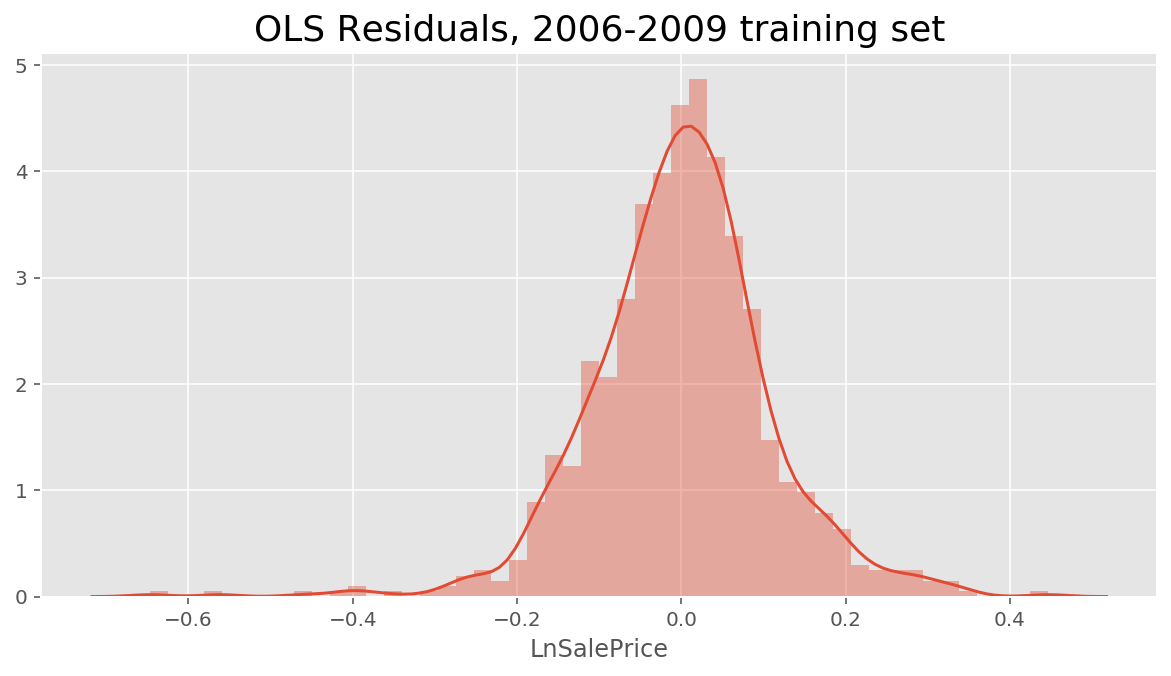

In [119]:
# The residuals are approximately normally distributed with mean 0
# There is an indication of a left-tail, indicating that the model overpredicts the target variable
# at the very low end of 'LnSalePrice'

fig, ax = plt.subplots(figsize=(10,5))
sns.distplot(ols_residuals_0609, bins=50, kde=True, ax=ax)
plt.title('OLS Residuals, 2006-2009 training set', fontsize=18)
plt.show()

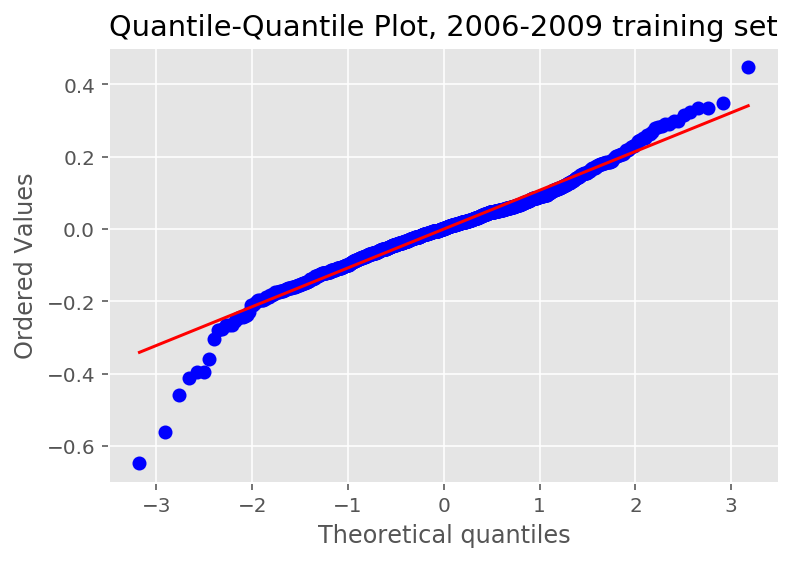

In [120]:
from scipy import stats
stats.probplot(ols_residuals_0609, dist="norm", plot=plt)
plt.title("Quantile-Quantile Plot, 2006-2009 training set")
plt.show()

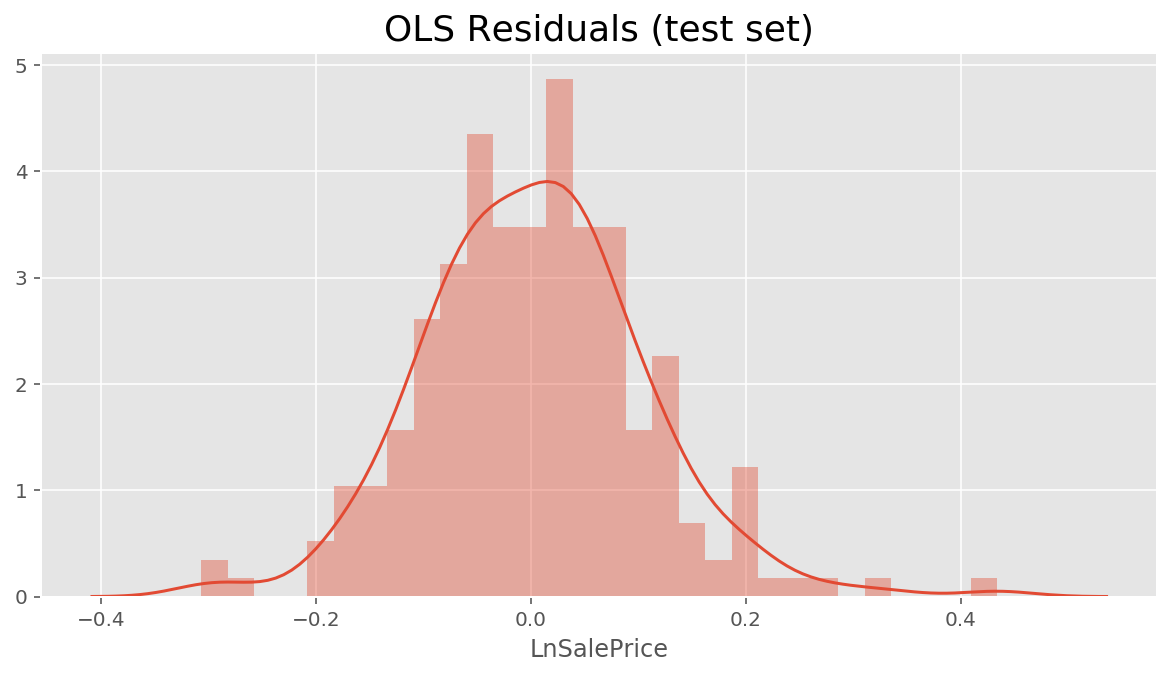

count    233.000000
mean       0.003574
std        0.102491
min       -0.306542
25%       -0.063998
50%        0.004293
75%        0.064495
max        0.433967
Name: LnSalePrice, dtype: float64

In [121]:
# The distribution of the test predictions are symmetric and approximately normal
ols_residuals_test = (y_test - predictions_test)

fig, ax = plt.subplots(figsize=(10,5))
sns.distplot(ols_residuals_test, bins=30, kde=True, ax=ax)
plt.title('OLS Residuals (test set)', fontsize=18)
plt.show()

ols_residuals_test.describe()

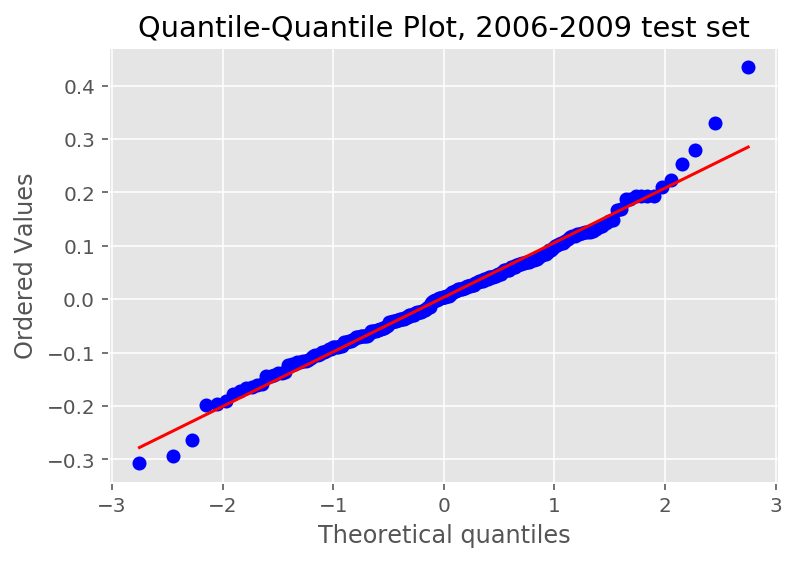

In [122]:
stats.probplot(ols_residuals_test, dist="norm", plot=plt)
plt.title("Quantile-Quantile Plot, 2006-2009 test set")
plt.show()

In [123]:
ols_residuals_test0609 = (y_test - predictions_test)
print("Skew:", ols_residuals_test0609.skew())
print("Kurtosis:", ols_residuals_test0609.kurtosis())
stat, p = shapiro(ols_residuals_test0609)
print('Shapiro-Wilk test on normality=%.3f, p=%.3f' % (stat, p))

Skew: 0.32782017965821786
Kurtosis: 1.484194225390222
Shapiro-Wilk test on normality=0.985, p=0.013


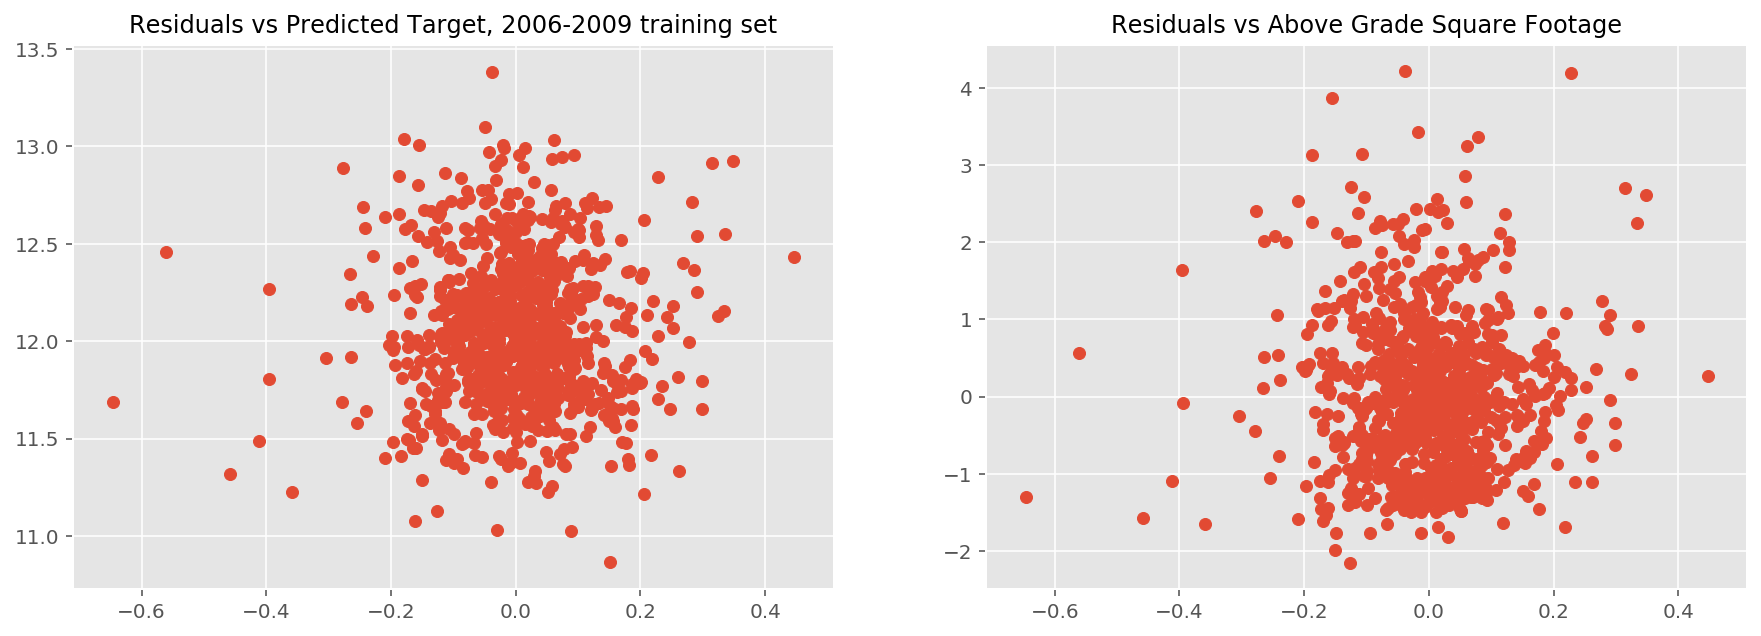

In [124]:
# Plotting the OLS residuals against the predicted-y and 'GrLivArea'. 
# The residuals appear well-behaved.
fig, ax = plt.subplots(ncols=2, figsize=(15, 5))
ax[0].scatter(ols_residuals_0609, predictions_train)
ax[0].set_title('Residuals vs Predicted Target, 2006-2009 training set', fontsize=12)
ax[1].scatter(ols_residuals_0609, X_train.GrLivArea)
ax[1].set_title('Residuals vs Above Grade Square Footage', fontsize=12)
plt.show()

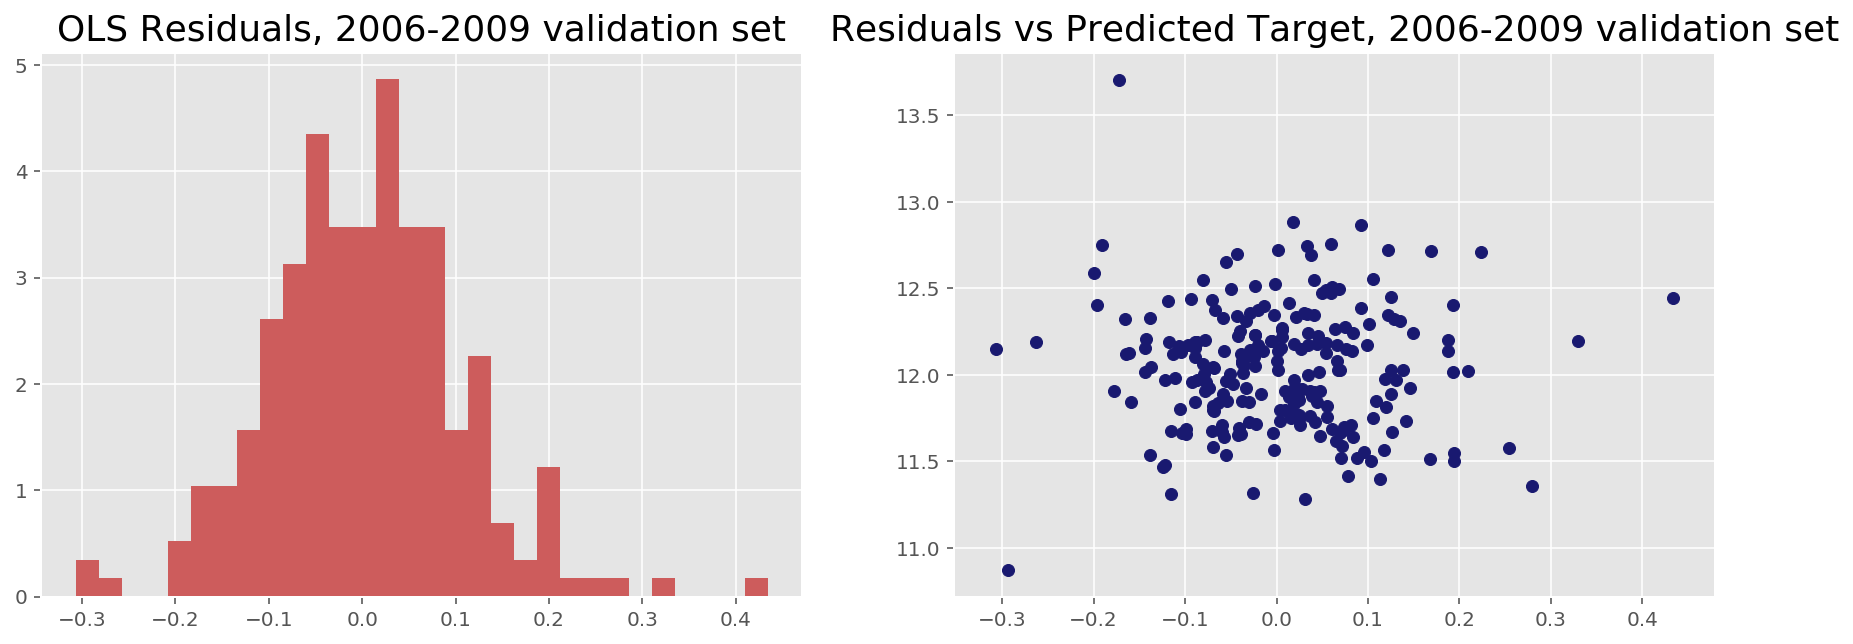

In [125]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 5))
ax[0].hist(ols_residuals_test, density=True, bins=30, color='indianred')
ax[0].set_title('OLS Residuals, 2006-2009 validation set', fontsize=18)
ax[1].scatter(ols_residuals_test, predictions_test, color='midnightblue')
ax[1].set_title('Residuals vs Predicted Target, 2006-2009 validation set', fontsize=18)
plt.show()

In [126]:
kf = KFold(n_splits=5, shuffle=True, random_state=1)
cv_scores_shuffled = cross_val_score(ols, X_train, y_train, cv=kf)

print('Shuffled cross validation score:', cv_scores_shuffled)
print('Mean shuffled cross validation score:', cv_scores_shuffled.mean())

Shuffled cross validation score: [0.93083895 0.9250268  0.90121438 0.90554693 0.90143002]
Mean shuffled cross validation score: 0.912811416658738


### Undertaking Ridge & Lasso CV

In [127]:
# Ridge Cross-Validation
ridge_mod = RidgeCV(alphas=np.logspace(-4, 4, 10), cv=5)
ridge_mod.fit(X_train, y_train)
print('Best Ridge alpha:', ridge_mod.alpha_)
print('Training score:', ridge_mod.score(X_train, y_train))
print("Test Score:", ridge_mod.score(X_test, y_test))

Best Ridge alpha: 2.782559402207126
Training score: 0.9203420815722757
Test Score: 0.9225128535501915


In [128]:
df_ridge_coef = pd.DataFrame(ridge_mod.coef_, index=X_train.columns,
                       columns=['Coefficients'])
df_ridge_coef['Coef_abs'] = df_ridge_coef.Coefficients.abs()

In [129]:
ridge_mod = Ridge(alpha=2.78)

scores = cross_val_score(ridge_mod, X_train, y_train, cv=5)
print("Cross-validated training scores:", scores)
print("Mean cross-validated training score:", scores.mean())

ridge_mod.fit(X_train, y_train)
print("Training Score:", ridge_mod.score(X_train, y_train))
print("Test Score:", ridge_mod.score(X_test, y_test))

Cross-validated training scores: [0.92496511 0.90526278 0.8881926  0.90570551 0.93881544]
Mean cross-validated training score: 0.9125882869133912
Training Score: 0.9203421027955908
Test Score: 0.9225129357396202


In [130]:
# Ridge Cross-Validation
ridge_mod = RidgeCV(alphas=np.logspace(-4, 4, 10), cv=5)
ridge_mod.fit(X_train, y_train)
print('Best Ridge alpha:', ridge_mod.alpha_)
print('Training score:', ridge_mod.score(X_train, y_train))
print("Test Score:", ridge_mod.score(X_test, y_test))

Best Ridge alpha: 2.782559402207126
Training score: 0.9203420815722757
Test Score: 0.9225128535501915


In [131]:
# Lasso Cross-Validation
lasso_mod = LassoCV(alphas=np.logspace(-4, 4, 10), cv=5)
lasso_mod.fit(X_train, y_train)

print('Best Lasso alpha:', lasso_mod.alpha_)
print('Training score:', lasso_mod.score(X_train, y_train))
print("Test Score:", lasso_mod.score(X_test, y_test))

Best Lasso alpha: 0.000774263682681127
Training score: 0.9201798694017025
Test Score: 0.9222567545273983


In [132]:
df_lasso_coef = pd.DataFrame(lasso_mod.coef_, index=X_train.columns,
                       columns=['Coefficients'])
df_lasso_coef['Coef_abs'] = df_lasso_coef.Coefficients.abs()

Both the coefficients and R-squared of the models I have used above appear very stable (so low variance) across the OLS, Ridge and Lasso models. The R-squared is approximately 0.89 across all 3 models, and across the training and test sets too.

In [133]:
coef_0609 = pd.concat([df_ols_coef['Coefficients'], df_ridge_coef['Coefficients'], df_lasso_coef['Coefficients']])
coef_0609 = pd.DataFrame(coef_0609)

In [134]:
coef_0609.reset_index(level=0, inplace=True)
coef_0609.columns = ['variable', 'coefficient']
coef_0609.shape

(81, 2)

In [135]:
coef_0609.loc[0:26, "model"] = "ols"
coef_0609.loc[27:54, "model"] = "ridge"
coef_0609.loc[55:82, "model"] = "lasso"

In [136]:
#coef_0609.sort_values('coefficient', inplace=True, ascending=False)
#coef_0609

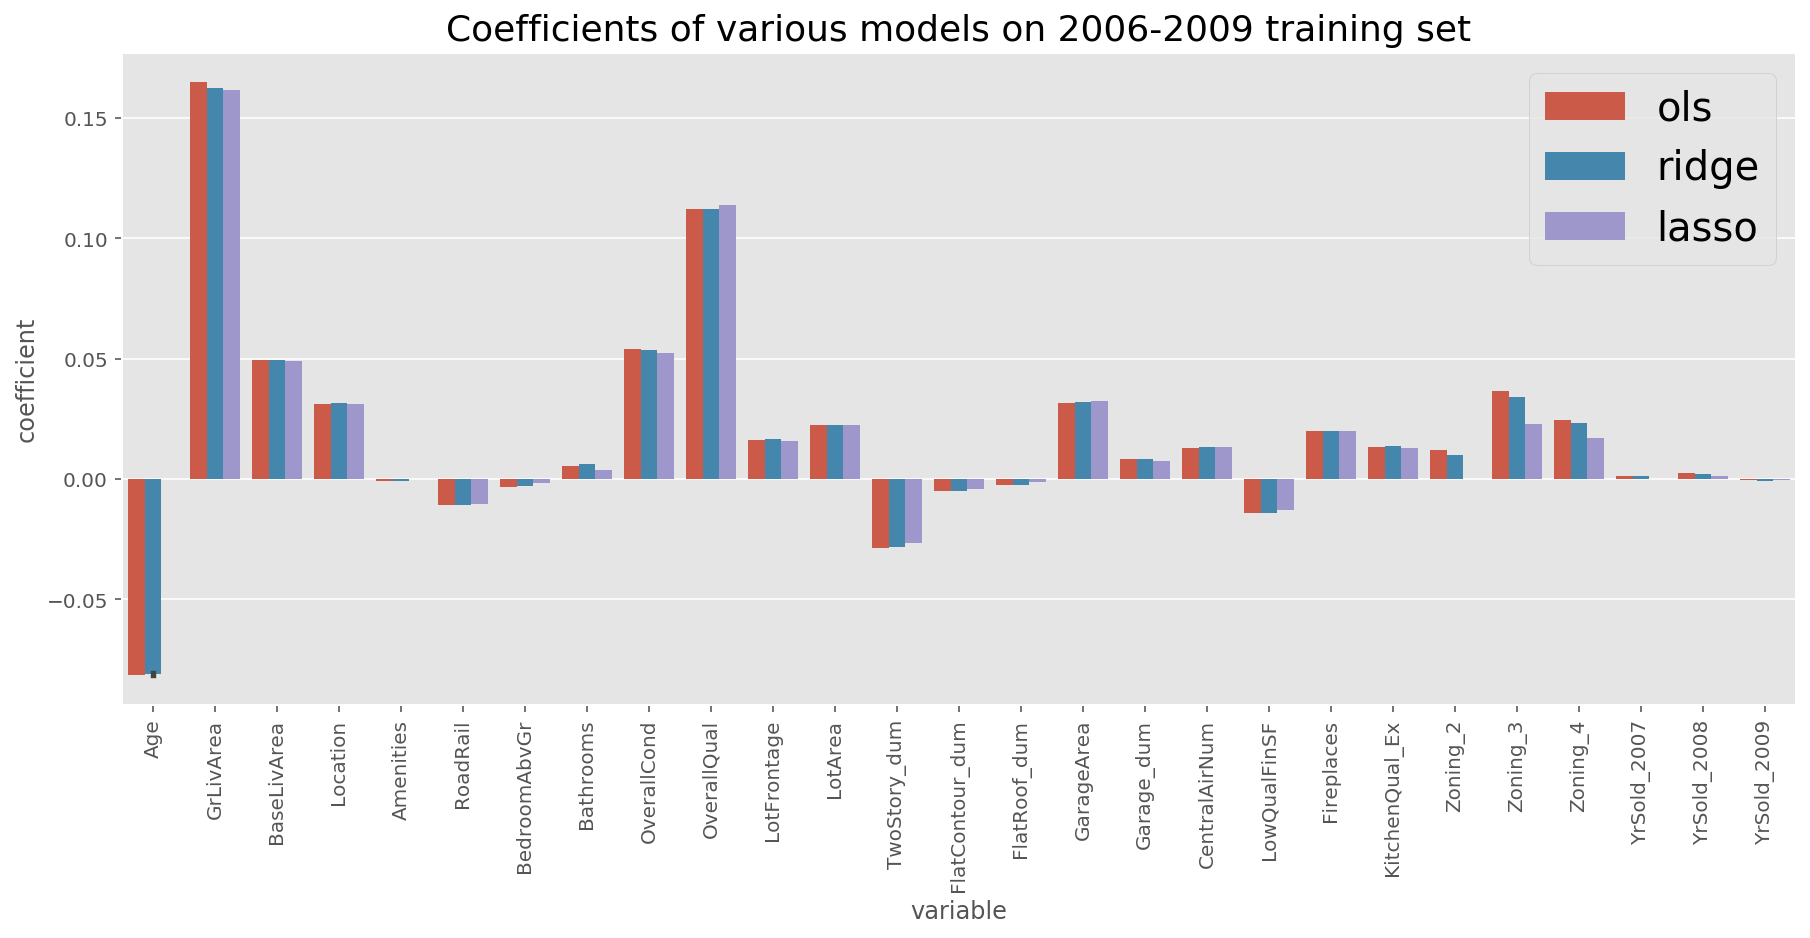

In [137]:
fig, ax = plt.subplots(figsize=(15,6))

sns.catplot(x='variable', y='coefficient', hue='model', data=coef_0609, kind='bar', ax=ax)
ax.set_xticklabels(labels=coef_0609.variable, rotation=90)
ax.set_title('Coefficients of various models on 2006-2009 training set', fontsize=18)
ax.set_xticklabels(labels=coef_0609.variable, rotation=90)
ax.legend(fontsize=20)
plt.close(2)
plt.show()

# Testing above model on the 2010 holdout data

In [138]:
y_train = df_0609['LnSalePrice']
y_lnSP_2010 = df_2010['LnSalePrice']

In [139]:
X_2010 = df_2010[['Age', 'GrLivArea', 'BaseLivArea', 'Location', 'Amenities', 'RoadRail', 'BedroomAbvGr', 'Bathrooms', 
                  'OverallCond', 'OverallQual', 'LotFrontage', 'LotArea', 'TwoStory_dum', 'FlatContour_dum', 'FlatRoof_dum', 
                  'GarageArea', 'Garage_dum', 'CentralAirNum', 'LowQualFinSF', 'Fireplaces', 'KitchenQual_Ex', 
                  'Zoning_2', 'Zoning_3', 'Zoning_4', 'YrSold_2007', 'YrSold_2008', 'YrSold_2009']]

In [140]:
X_train = df_0609[['Age', 'GrLivArea', 'BaseLivArea', 'Location', 'Amenities', 'RoadRail', 'BedroomAbvGr', 'Bathrooms', 
                  'OverallCond', 'OverallQual', 'LotFrontage', 'LotArea', 'TwoStory_dum', 'FlatContour_dum', 'FlatRoof_dum', 
                  'GarageArea', 'Garage_dum', 'CentralAirNum', 'LowQualFinSF', 'Fireplaces', 'KitchenQual_Ex', 
                  'Zoning_2', 'Zoning_3', 'Zoning_4', 'YrSold_2007', 'YrSold_2008', 'YrSold_2009']]

In [141]:
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_2010), columns=X_2010.columns)

In [142]:
ols.fit(X_train, y_train) 
predictions_train = ols.predict(X_train)
predictions_test = ols.predict(X_test)

cv_scores = cross_val_score(ols, X_train, y_train, cv=5)

print('Training Score:', ols.score(X_train, y_train))
print('Cross validation score:', cv_scores)
print('Mean cross validation score:', cv_scores.mean())
print('2010 holdout data score:', ols.score(X_test, y_lnSP_2010))

Training Score: 0.9212911124503878
Cross validation score: [0.92051141 0.92817339 0.90806628 0.91375904 0.8967103 ]
Mean cross validation score: 0.9134440842943444
2010 holdout data score: 0.9006873149783733


In [143]:
ols_residuals_2010 = (y_lnSP_2010 - predictions_test)
ols_residuals_2010.describe()

count    160.000000
mean       0.010795
std        0.118785
min       -0.413502
25%       -0.069310
50%        0.022901
75%        0.084475
max        0.334438
Name: LnSalePrice, dtype: float64

In [144]:
print("Skew:", ols_residuals_2010.skew())
print("Kurtosis:", ols_residuals_2010.kurtosis())
stat, p = shapiro(ols_residuals_2010)
print('Shapiro-Wilk test on normality=%.3f, p=%.3f' % (stat, p))

Skew: -0.4757170378704235
Kurtosis: 0.7941190728672973
Shapiro-Wilk test on normality=0.983, p=0.049


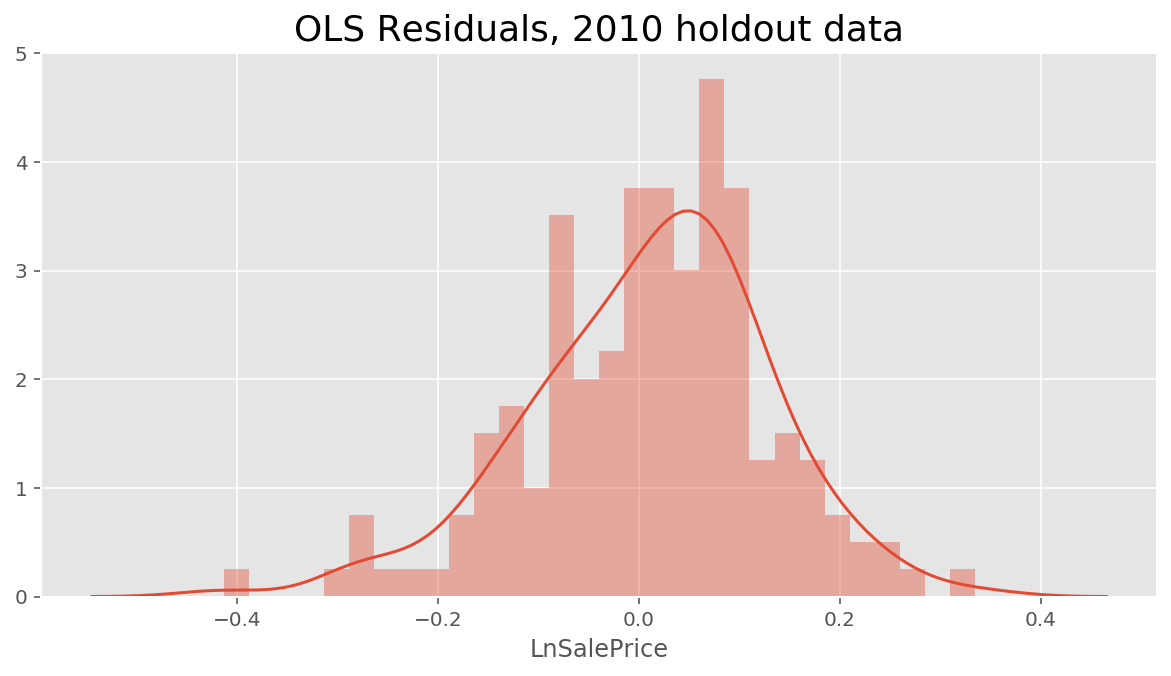

In [145]:
# For the 2010 test data, the residuals' is approximately symmetric with a slight left-tail,
# and a mean centred near zero but slightly positive
ols_residuals_2010 = (y_lnSP_2010 - predictions_test)

fig, ax = plt.subplots(figsize=(10,5))
sns.distplot(ols_residuals_2010, bins=30, kde=True, ax=ax)
plt.title('OLS Residuals, 2010 holdout data', fontsize=18)
plt.show()

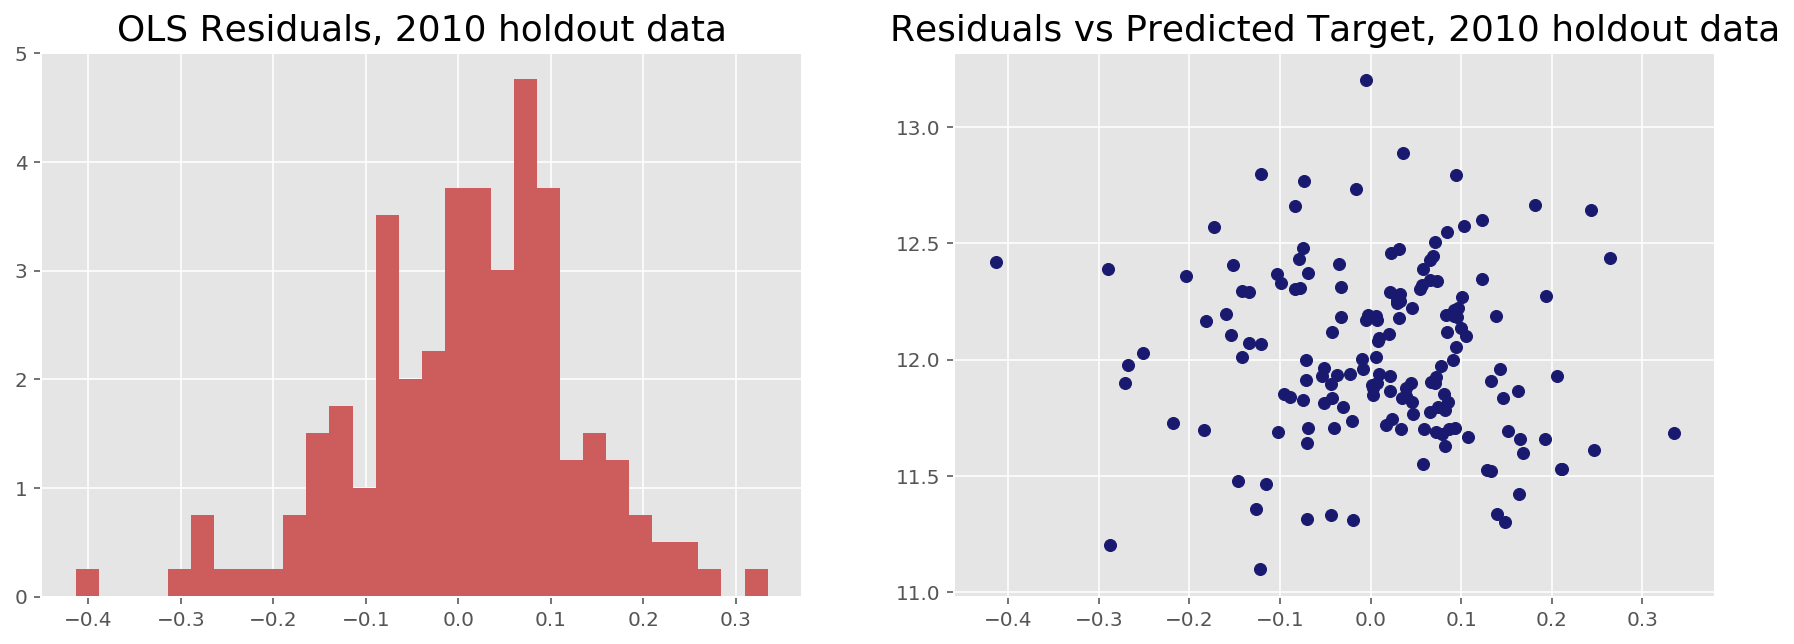

In [146]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 5))
ax[0].hist(ols_residuals_2010, density=True, bins=30, color='indianred')
ax[0].set_title('OLS Residuals, 2010 holdout data', fontsize=18)
ax[1].scatter(ols_residuals_2010, predictions_test, color='midnightblue')
ax[1].set_title('Residuals vs Predicted Target, 2010 holdout data', fontsize=18)
plt.show()

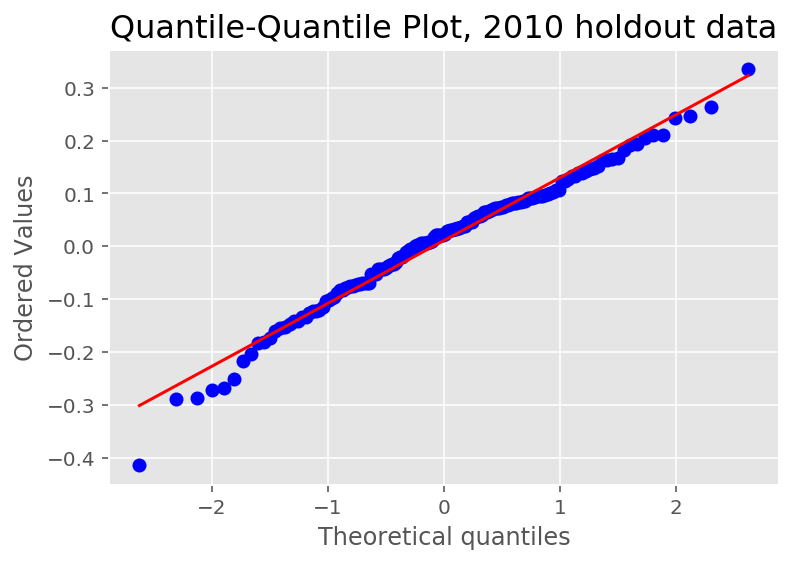

In [147]:
from scipy import stats
stats.probplot(ols_residuals_2010, dist="norm", plot=plt)
plt.title("Quantile-Quantile Plot, 2010 holdout data", fontsize=16)
plt.show()

In [148]:
ridge_mod = RidgeCV(alphas=np.logspace(-4, 4, 10), cv=5)
ridge_mod.fit(X_train, y_train)
print('Best Ridge alpha:', ridge_mod.alpha_)
print('Training score:', ridge_mod.score(X_train, y_train))
print("2010 holdout data score:", ridge_mod.score(X_test, y_lnSP_2010))

Best Ridge alpha: 2.782559402207126
Training score: 0.921282789221318
2010 holdout data score: 0.9008388145502991


In [149]:
lasso_mod = LassoCV(alphas=np.logspace(-4, 4, 10), cv=5)
lasso_mod.fit(X_train, y_train)

print('Best Lasso alpha:', lasso_mod.alpha_)
print('Training score:', lasso_mod.score(X_train, y_train))
print("2010 holdout data score:", lasso_mod.score(X_test, y_lnSP_2010))

Best Lasso alpha: 0.000774263682681127
Training score: 0.921135852986179
2010 holdout data score: 0.9009047800004807


Using the 2010 data as the test set, we see that the R-squared drops slightly to 0.90 from the 0.92 achieved in the 2006-2009 training set. The residuals' distribution has a very slight positive mean value and a longer left-tail, but it looks approximately normal.

# Regression model using full 2006-2010 data

In [150]:
y_lnSP = df_exout['LnSalePrice']
y_lnPSF = df_exout['LnPriceSF']

In [151]:
X_fin = df_exout[['Age', 'GrLivArea', 'BaseLivArea', 'Location', 'Amenities', 'RoadRail', 'BedroomAbvGr', 'Bathrooms', 
                  'OverallCond', 'OverallQual', 'LotFrontage', 'LotArea', 'TwoStory_dum', 'FlatContour_dum', 'FlatRoof_dum', 
                  'GarageArea', 'Garage_dum', 'CentralAirNum', 'LowQualFinSF', 'Fireplaces', 'KitchenQual_Ex', 
                  'Zoning_2', 'Zoning_3', 'Zoning_4', 'YrSold_2007', 'YrSold_2008', 'YrSold_2009', 'YrSold_2010']]

In [152]:
X_fin.shape

(1323, 28)

In [153]:
X_fin = pd.DataFrame(scaler.fit_transform(X_fin), columns=X_fin.columns)

In [154]:
from sklearn import metrics
ols.fit(X_fin, y_lnSP) 
predictions = ols.predict(X_fin)
print('R-squared:', ols.score(X_fin, y_lnSP))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_lnSP, predictions))  
print('Mean Squared Error:', metrics.mean_squared_error(y_lnSP, predictions))  

R-squared: 0.9191658607265705
Mean Absolute Error: 0.08053301649907656
Mean Squared Error: 0.011782394971720548


In [155]:
df_LnSP_coef = pd.DataFrame(ols.coef_, index=X_fin.columns,
                       columns=['Coefficients'])
df_LnSP_coef['Coef_abs'] = df_LnSP_coef.Coefficients.abs()

In [156]:
error_term = (y_lnSP - predictions)
error_term.describe()

count    1.323000e+03
mean    -1.248686e-15
std      1.085878e-01
min     -6.393039e-01
25%     -6.255451e-02
50%      3.152189e-03
75%      6.018241e-02
max      4.557514e-01
Name: LnSalePrice, dtype: float64

In [157]:
# Residuals are approximately normal, given the skew and kurtosis
print("Skew:", error_term.skew())
print("Kurtosis:", error_term.kurtosis())
stat, p = shapiro(error_term)
print('Shapiro-Wilk test on normality=%.3f, p=%.3f' % (stat, p))

Skew: -0.30224073818827035
Kurtosis: 2.695035747871477
Shapiro-Wilk test on normality=0.974, p=0.000


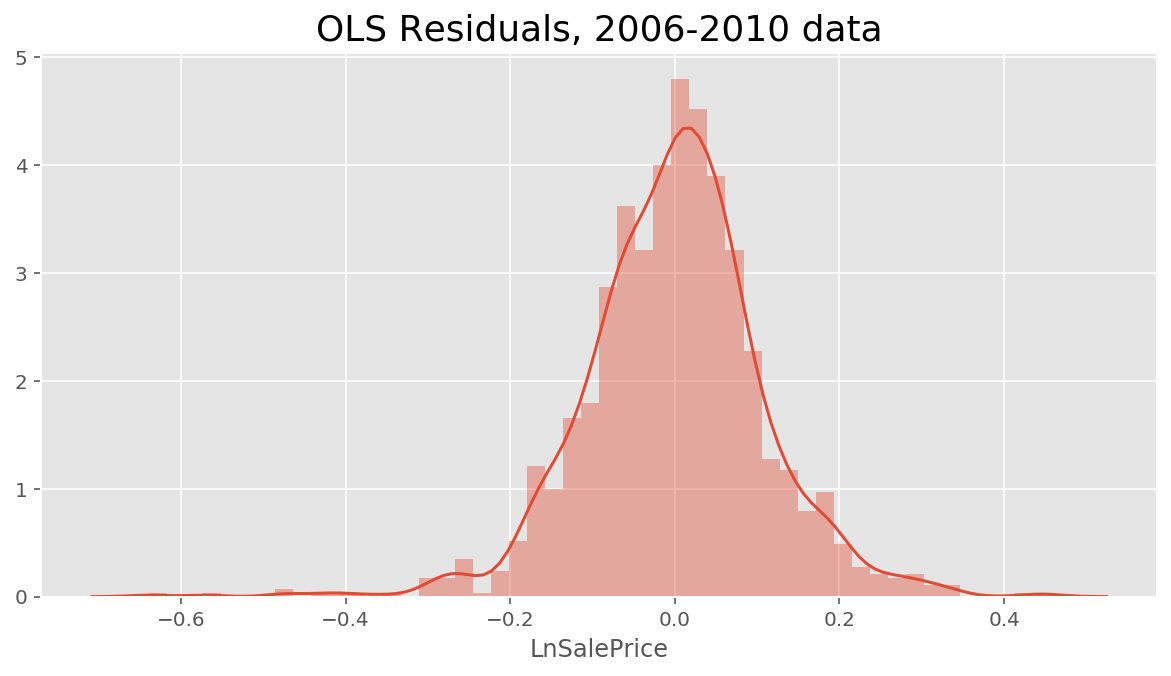

In [158]:
fig, ax = plt.subplots(figsize=(10,5))
sns.distplot(error_term, bins=50, kde=True, ax=ax)
plt.title('OLS Residuals, 2006-2010 data', fontsize=18)
plt.show()

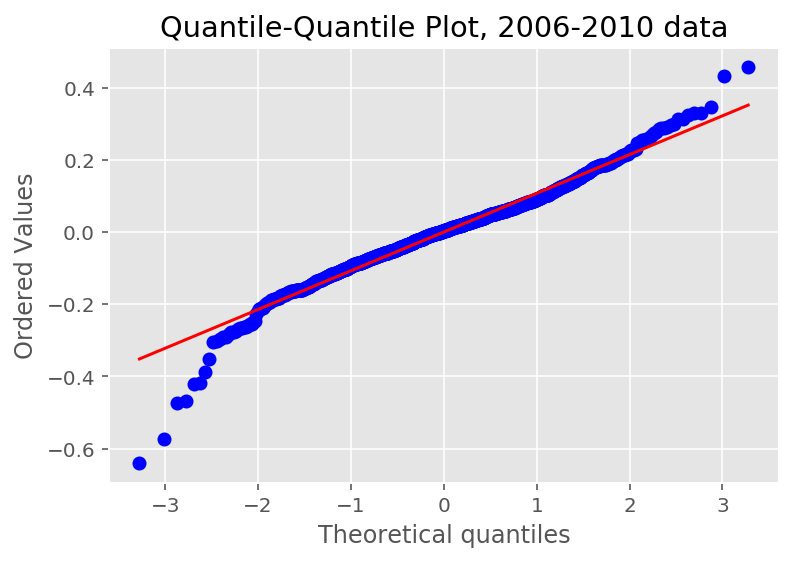

In [159]:
from scipy import stats
stats.probplot(error_term, dist="norm", plot=plt)
plt.title("Quantile-Quantile Plot, 2006-2010 data")
plt.show()

In [160]:
# Doing the unscaled regression to get the unstandardised coefficients
X_fin = df_exout[['Age', 'GrLivArea', 'BaseLivArea', 'Location', 'Amenities', 'RoadRail', 'BedroomAbvGr', 'Bathrooms', 
                  'OverallCond', 'OverallQual', 'LotFrontage', 'LotArea', 'TwoStory_dum', 'FlatContour_dum', 'FlatRoof_dum', 
                  'GarageArea', 'Garage_dum', 'CentralAirNum', 'LowQualFinSF', 'Fireplaces', 'KitchenQual_Ex', 
                  'Zoning_2', 'Zoning_3', 'Zoning_4', 'YrSold_2007', 'YrSold_2008', 'YrSold_2009', 'YrSold_2010']]

In [161]:
ols.fit(X_fin, y_lnSP)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [162]:
df_unscaled_coef = pd.DataFrame(ols.coef_, index=X_fin.columns, columns=['Coefficients'])
df_unscaled_coef['Coef_abs'] = df_unscaled_coef.Coefficients.abs()
df_unscaled_coef

,Coefficients,Coef_abs
Age,-0.002744,0.002744
GrLivArea,0.000331,0.000331
BaseLivArea,0.000102,0.000102
Location,0.030364,0.030364
Amenities,-0.042516,0.042516
RoadRail,-0.045345,0.045345
BedroomAbvGr,-0.007978,0.007978
Bathrooms,0.005716,0.005716
OverallCond,0.048834,0.048834
OverallQual,0.080793,0.080793


In [163]:
import math

transformed_coef = []
for x in df_unscaled_coef.iloc[:,0]:
    y = math.exp(x)
    transformed_coef.append(y)

print(transformed_coef)

[0.9972593234662767, 1.0003306164931838, 1.0001022646284028, 1.0308297706990746, 0.9583749036545426, 0.9556681049673661, 0.9920535436908299, 1.005732002866626, 1.0500464829168625, 1.0841469476422896, 1.0006828360260984, 1.0000026936641095, 0.9435418033269554, 0.9830425418989427, 1.0314170260712052, 1.0001530223002109, 1.0429576486502472, 1.060655902179357, 0.9997182062736214, 1.0258019759072596, 1.0817700419385083, 1.0313783705272495, 1.092747608550722, 1.1114288154908811, 1.0054532214041405, 1.0066426316037242, 0.9969139676101554, 1.011380647250251]


In [164]:
coef_effect = [(x - 1)*df_exout.SalePrice.mean() for x in transformed_coef]
print(coef_effect)

[-501.18774559380796, 60.459865597417036, 18.70114109874671, 5637.842731061591, -7611.984829586162, -8106.977330565195, -1453.1691259610352, 1048.2118408036383, 9152.004492089887, 15387.959311690349, 124.87028086658871, 0.4925905796751659, -10324.515119780803, -3101.0117728575015, 5745.234169790104, 27.983200762502328, 7855.668780357291, 11092.149874735702, -51.53164217241585, 4718.409479449571, 14953.29436801355, 5738.165227252922, 16960.7628871119, 20376.99675349597, 997.2310515798264, 1214.7385936704654, -564.3429997171005, 2081.1799088901143]


### Coefficient standard errors and p-values

In [165]:
from sklearn import linear_model
from regressors import stats

ols = linear_model.LinearRegression()
ols.fit(X_fin, y_lnSP)

print("\n================ SUMMARY TABLE WITH P-VALUES =================")
xlabels = X_fin.columns
stats.summary(ols, X_fin, y_lnSP, xlabels)


================ SUMMARY TABLE WITH P-VALUES =================
Residuals:
    Min      1Q  Median      3Q     Max
-0.4558 -0.0602 -0.0032  0.0626  0.6393


Coefficients:
                  Estimate  Std. Error   t value   p value
_intercept       10.453595    0.041556  251.5550  0.000000
Age              -0.002744    0.000101  -27.2914  0.000000
GrLivArea         0.000331    0.000004   78.2014  0.000000
BaseLivArea       0.000102    0.000007   15.0349  0.000000
Location          0.030364    0.003355    9.0495  0.000000
Amenities        -0.042516    0.021966   -1.9356  0.053133
RoadRail         -0.045345    0.012777   -3.5488  0.000401
BedroomAbvGr     -0.007978    0.004930   -1.6182  0.105856
Bathrooms         0.005716    0.008779    0.6511  0.515123
OverallCond       0.048834    0.002751   17.7518  0.000000
OverallQual       0.080793    0.003232   24.9995  0.000000
LotFrontage       0.000683    0.000138    4.9326  0.000001
LotArea           0.000003    0.000000   10.7917  0.000000
Two